In [1]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
import pickle
import Estimate_Covariance_Matrix
import os
import prepare_portfolio_data
import portfolio_choice_functions
import scipy.linalg
import matplotlib.pyplot as plt
import re
import pickle
start_date = pd.to_datetime('1952-12-31')

file_path_cluster_labels = "Data/Cluster Labels.csv"
file_path_factor_details = "Data/Factor Details.xlsx"


folder_name = "much_more_data"


Features list length: 154


In [2]:
output_path = os.path.join(".", folder_name, "")
market_path = os.path.join(".", folder_name, "market_returns_test.csv")
pickle_file_path = os.path.join(".", folder_name, "model_1.pkl")
wealth_path = os.path.join(".", folder_name, "wealth.csv")
barra_file_path = os.path.join(".", folder_name, "barra_cov.pkl")
output_path_market_returns = os.path.join(folder_name, "market_returns_test.csv")

risk_free_path = os.path.join(".", folder_name, "risk_free_test.csv")
#risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date, output_path = risk_free_path)
risk_free_path = "./data_fifty/risk_free_test.csv" 
risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
output_data_ret_csv = os.path.join(".", folder_name, "data_ret.csv")
output_data_ret_ld1_csv = os.path.join(".", folder_name, "data_ret_ld1.csv")
daily_path = os.path.join(".", folder_name, "daily.csv")
chars_path = os.path.join(".", folder_name, "chars_behandlet.parquet")
file_path_world_ret = os.path.join(".", folder_name, "world_ret_test.csv")
daily_file_path = os.path.join(".", folder_name, "usa_dsf_test.parquet")
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
output_path_chars_behandlet =  os.path.join(".", folder_name, "chars_behandlet.parquet")
output_path_daily = os.path.join(".", folder_name, "daily.csv")
# Paths for Data-mappen forbliver uændrede
file_path_cluster_labels = os.path.join("Data", "Cluster Labels.csv")
file_path_factor_details = os.path.join("Data", "Factor Details.xlsx")

Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


In [4]:
wealth = pd.read_csv(wealth_path)
wealth['eom'] = pd.to_datetime(wealth['eom'])
data_ret = pd.read_csv(output_data_ret_csv)
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)
data_ret['eom'] = pd.to_datetime(data_ret['eom'])
data_ret_ld1['eom'] = pd.to_datetime(data_ret_ld1['eom'])
data_ret_ld1['eom_ret'] = pd.to_datetime(data_ret_ld1['eom_ret'])
daily = pd.read_csv(daily_path, parse_dates=["date", "eom"])
chars = pd.read_parquet(chars_path)

#Disse er alle korrekte

In [5]:
with open(barra_file_path, "rb") as file:
    barra_cov = pickle.load(file)

In [6]:
def add_return_predictions(chars, settings, get_from_path_model):
    for h in range(1, 2):  # Hardcoded: 1 horizon
        #file_path = os.path.join(get_from_path_model, f"demeaned_model_{h}_seed10.pkl")
        file_path = os.path.join(get_from_path_model, f"model_{h}_seed10.pkl")
        with open(file_path, 'rb') as f:
            model_dict = pickle.load(f)  # Indlæs pickle-fil

        # Ekstraher og fjern den månedlige gennemsnits-dataFrame fra model_dict
 #       monthly_means_df = model_dict["monthly_means_df"]
 #       del model_dict["monthly_means_df"]

        # Iterer over dato-nøgler og udtræk forudsigelser
        all_preds = []
        for date_key, subdict in model_dict.items():
            # Antag at hver subdictionary indeholder en key "pred"
            pred_df = pd.DataFrame(subdict['pred'])
            all_preds.append(pred_df)
            
        # Saml alle forudsigelsesdata
        pred_df_all = pd.concat(all_preds, ignore_index=True)
        pred_df_all = pred_df_all[['id', 'eom', 'pred']].rename(columns={'pred': f'pred_ld{h}'})
        
        # Først merge de de-meanede forudsigelser ind i chars
        chars = chars.merge(pred_df_all, on=['id', 'eom'], how='left')
        # Dernæst merge monthly means (gennemsnitsafkast) ind i chars baseret på 'eom'
   #     chars = chars.merge(monthly_means_df, on='eom', how='left')
        # Tilføj det månedlige gennemsnitsafkast til de de-meanede *forudsigelser for at få den endelige prediction
        # Fjern eventuelt mean_ret-kolonnen, hvis du ikke behøver den
    #    chars = chars.drop(columns=['mean_ret'])
        
    return chars


In [7]:
chars = add_return_predictions(chars,settings, output_path)

lambda_list = prepare_portfolio_data.create_lambda_list(chars)

first_cov_date, hp_years, start_oos = prepare_portfolio_data.define_important_dates(barra_cov, settings)
date_ranges = prepare_portfolio_data.create_date_ranges(settings, first_cov_date, start_oos, hp_years)
dates_m1 = date_ranges["dates_m1"]
dates_m2 = date_ranges["dates_m2"]
dates_oos = date_ranges["dates_oos"]
dates_hp = date_ranges["dates_hp"]

C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.6.1. This might lead to breaking cod

In [70]:
output_folder = r"C:\Users\jonas\OneDrive\CBS\Kandidat - CBS\Speciale\Resultater Python"

In [13]:
# Hvis wealth skal æændres, så ændrer vi bare wealth_end
wealth_end_new = 1000000000 #1e9 er vores base case
end = settings["split"]["test_end"]
market_test = Prepare_Data.load_and_filter_market_returns_test(market_path)
wealth = Prepare_Data.wealth_func(wealth_end_new, end, market_test, risk_free)

Filen er indlæst og filtreret succesfuldt.


In [15]:
market_path = os.path.join(".", folder_name, "market_returns_test.csv")
market = Prepare_Data.load_and_filter_market_returns_test(market_path)
market

Filen er indlæst og filtreret succesfuldt.


,eom,mkt_vw_exc
0,1952-12-31,0.029113
1,1953-01-31,-0.003177
2,1953-02-28,-0.003027
3,1953-03-31,-0.014660
4,1953-04-30,-0.029152
...,...,...
836,2022-08-31,-0.038088
837,2022-09-30,-0.093270
838,2022-10-31,0.079050
839,2022-11-30,0.048429


# IEF - kun Markowitz del - uden demean - denne virker ok uden demean

In [143]:
pf_set["gamma_rel"]

10

In [144]:
tpf = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

In [145]:
tpf_base = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

In [146]:
tpf['w']

,id,eom,w_start,w,tr_ld1,mu_ld1
0,10032,2010-12-31,0.000115,-0.000774,NaN,NaN
1,10032,2011-01-31,-0.000663,0.036959,-0.126016,0.020052
2,10032,2011-02-28,0.041353,0.022751,0.162330,0.038821
3,10032,2011-03-31,0.025293,0.004913,0.115528,0.003383
4,10032,2011-04-30,0.004976,-0.032684,0.040834,0.027662
...,...,...,...,...,...,...
102047,92655,2022-07-31,-0.017434,0.028970,0.055684,0.093630
102048,92655,2022-08-31,0.028749,0.052953,-0.043528,-0.036188
102049,92655,2022-09-30,0.056857,0.043725,-0.024368,-0.091370
102050,92655,2022-10-31,0.044430,0.087492,0.098793,0.081350


In [147]:
tpf['pf']

,inv,shorting,turnover,r,tc,eom_ret,type
0,52.873694,26.312257,52.821418,0.222189,14.109611,2011-01-31,Markowitz-ML
1,52.292950,25.904092,58.473896,0.342139,15.523369,2011-02-28,Markowitz-ML
2,53.050675,26.499269,57.329286,0.322649,15.815820,2011-03-31,Markowitz-ML
3,56.701681,28.284691,58.255849,0.100339,16.437864,2011-04-30,Markowitz-ML
4,57.515120,28.608557,63.347825,0.024859,17.671906,2011-05-31,Markowitz-ML
...,...,...,...,...,...,...,...
139,21.973375,10.695547,17.623603,-0.098427,2.716235,2022-08-31,Markowitz-ML
140,22.961619,11.205824,15.694254,-0.008155,2.278192,2022-09-30,Markowitz-ML
141,23.066299,11.279464,16.731162,0.180818,2.599016,2022-10-31,Markowitz-ML
142,21.620818,10.541493,18.192323,-0.020208,3.742034,2022-11-30,Markowitz-ML


In [148]:
tpf['pf']['r'].std()*np.sqrt(12)
import numpy as np

# hvis tpf_base svarer til dit R‐objekt med elementet 'pf':
tpf_base_vol = tpf['pf']['r'].std(ddof=1) * np.sqrt(12)
tpf_base_vol

0.45591025796693524

In [149]:
def mv_risky_fun(data, cov_list, wealth, dates, gam, u_vec):
    # Filtrér data: behold kun de rækker, der er gyldige og hvor 'eom' er blandt de ønskede datoer.
    # Udvælg kun de relevante kolonner.
    data_rel = data.loc[(data["valid"]) & (data["eom"].isin(dates)), ["id", "eom", "me", "tr_ld1", "pred_ld1"]].copy()
    # Sortér efter "id" og "eom" for konsistens
    data_rel = data_rel.sort_values(by=["id", "eom"])
    
    # Split data_rel i en dictionary, hvor hver nøgle er en dato (som str, fx "2010-12-31")
    data_split = {}
    for eom_val, group in data_rel.groupby("eom"):
        # Konverter eom til string, hvis det er et datetime-objekt:
        if hasattr(eom_val, "strftime"):
            key = eom_val.strftime('%Y-%m-%d')
        else:
            key = str(eom_val)
        data_split[key] = group.copy()
    
    mv_opt_all = []  # Liste til at samle optimale weights per dato og u
    
    # Loop over datoerne i 'dates'
    for d in dates:
        # Konverter d til string med formatet 'YYYY-MM-DD'
        if hasattr(d, "strftime"):
            d_str = d.strftime('%Y-%m-%d')
        else:
            d_str = str(d)
        if d_str not in data_split:
            print(f"Advarsel: Ingen data for dato {d_str}")
            continue
        data_sub = data_split[d_str]
        ids = data_sub["id"]
        
        # Hent kovariansmatrixen for datoen via create_cov. Sørg for, at ids (som str) overholder den forventede rækkefølge.
        sigma = General_Functions.create_cov(cov_list[d_str], ids=ids.astype(str))
        # Inverter sigma
        sigma_inv = np.linalg.inv(sigma)
        
        # Udtræk forventede returneringsværdier fra 'pred_ld1'
        er = data_sub["pred_ld1"].values
        # Opret en vektor med 1'ere (samme længde som er)
        ones = np.ones_like(er)
        
        # Beregn parameterne a, b, c og d (som i R-koden)
        a = er.T @ sigma_inv @ er
        b = sigma_inv @ er
        c = sigma_inv @ ones
        d_aux = a * c.sum() - (b.sum())**2
        
        # For hvert u i u_vec beregnes de optimale weights
        for u in u_vec:
            # Den optimale vægtberegning (svarer til R: ((sum(c)*u - sum(b))/d)* (sigma_inv %*% er) + ((a - sum(b)*u)/d)*(sigma_inv %*% ones))
            weights = ((c.sum() * u - b.sum()) / d_aux) * (sigma_inv @ er) + \
                      ((a - b.sum() * u) / d_aux) * (sigma_inv @ ones)
            # Lav en DataFrame for de aktuelle weights
            weights_df = pd.DataFrame({
                "id": data_sub["id"].values,
                "eom": d,
                "u": u * 12,  # Konverter u til årlig basis
                "w": weights
            })
            mv_opt_all.append(weights_df)
    
    # Saml alle vægtdata til én DataFrame
    mv_opt_all = pd.concat(mv_opt_all, ignore_index=True)
    
    # Byg porteføljer: For hver unik u-værdi, anvendes funktionen w_fun og pf_ts_fun til at beregne porteføljen.
    results = []
    for u_sel in mv_opt_all["u"].unique():
        # Vælg de vægte, der svarer til u_sel
        w = mv_opt_all[mv_opt_all["u"] == u_sel].copy()
        # Vi antager, at w_fun beregner porteføljens vægte, givet data_rel, datoer og wealth.
        weights = portfolio_choice_functions.w_fun(data_rel, dates, w, wealth)
        # Herefter anvendes pf_ts_fun til at beregne porteføljens tidsserieudvikling.
        portfolio = portfolio_choice_functions.pf_ts_fun(weights, data, wealth, gam)
        portfolio["u"] = u_sel
        results.append(portfolio)
    
    return pd.concat(results, ignore_index=True)


In [150]:
# 1) Baseline-vol
# månedligt brutto-r i pf, annualiseret vol
tpf_base_vol = tpf['pf']['r'].std() * np.sqrt(12)

# 2) Vol-mål
vol_range = np.arange(0, 0.5, 0.001)

# 3) Loop: skaler, backtest, append
ef_list = []

for vol_target in vol_range:
    scale = vol_target / tpf_base_vol

    # skaler vægtene
    w_scaled = tpf['w'].copy()
    w_scaled['w']       *= scale
    w_scaled['w_start'] *= scale

    # kald pf_ts_fun med den korrekte signatur:
    pf_res = portfolio_choice_functions.pf_ts_fun(
        w_scaled,          # 1) vægt‑DataFrame
        chars,             # 2) data
        wealth,            # 3) wealth‐parameter
        pf_set["gamma_rel"]# 4) risk‐aversion
    )

    pf_res['vol_target'] = vol_target
    pf_res['type']       = "Markowitz-ML"
    ef_list.append(pf_res)

# 4) Saml alt i én DataFrame
tpf_ef = pd.concat(ef_list, ignore_index=True)

# 5) Opsummer (præcis som i R)
def summarize(g):
    r   = g['r']
    tc  = g['tc']
    G   = pf_set["gamma_rel"]
    return pd.Series({
        'n'        : len(g),
        'inv'      : g['inv'].mean(),
        'to'       : g['turnover'].mean(),
        'r'        : r.mean() * 12,
        'sd'       : r.std() * np.sqrt(12),
        'sr_gross' : (r.mean()/r.std()) * np.sqrt(12),
        'tc'       : tc.mean() * 12,
        'r_tc'     : (r - tc).mean() * 12,
        'sr'       : ((r-tc).mean()/r.std()) * np.sqrt(12),
        'obj'      : (r.mean() - 0.5 * r.var() * G - tc.mean()) * 12
    })

tpf_ss = (
    tpf_ef
    .groupby('vol_target')
    .apply(summarize)
    .reset_index()
)

print(tpf_ss.head())


C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\2753230274.py:45: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\2753230274.py:48: RuntimeWarning: invalid value encountered in scalar divide


   vol_target      n       inv        to         r     sd  sr_gross        tc  \
0       0.000  144.0  0.000000  0.000000  0.000000  0.000       NaN  0.000000   
1       0.001  144.0  0.071999  0.063627  0.000982  0.001  0.982119  0.000343   
2       0.002  144.0  0.143998  0.127254  0.001964  0.002  0.982119  0.001372   
3       0.003  144.0  0.215997  0.190881  0.002946  0.003  0.982119  0.003087   
4       0.004  144.0  0.287997  0.254508  0.003928  0.004  0.982119  0.005488   

       r_tc        sr       obj  
0  0.000000       NaN  0.000000  
1  0.000639  0.639123  0.000634  
2  0.000592  0.296128  0.000572  
3 -0.000141 -0.046867 -0.000186  
4 -0.001559 -0.389862 -0.001639  


C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\2753230274.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [151]:
tpf_base_vol

0.45591025796693524

In [25]:
import numpy as np

# Som i R: linjeært grid i [-0.5,0.5] plus nogle ekstra punkter, alt i årlig, så /12
u_vec = np.concatenate([
    np.arange(-0.5, 0.51, 0.05),
    [0.6, 0.75, 1, 2]
]) / 12

# Beregn wealth_0 på samme måde som i R (kræver din wealth_func):
from Prepare_Data import wealth_func
wealth_0 = wealth_func(
    wealth_end = 0,
    end        = settings['split']['test_end'],
    market     = market,
    risk_free  = risk_free
)


In [152]:
mv_res = mv_risky_fun(
    data     = chars,
    cov_list = barra_cov,
    wealth   = wealth_0,
    dates    = dates_oos,
    gam      = pf_set['gamma_rel'],
    u_vec    = u_vec
)


In [153]:
import pandas as pd

def summarize_mv(g):
    r   = g['r']      # månedligt brutto‐ret i gruppe
    tc  = g['tc']     # månedlig trading‐cost
    G   = pf_set['gamma_rel']
    
    return pd.Series({
        'n'        : len(g),
        'inv'      : g['inv'].mean(),
        'to'       : g['turnover'].mean(),
        'r'        : r.mean() * 12,
        'sd'       : r.std(ddof=1) * np.sqrt(12),
        'sr_gross' : (r.mean()/r.std(ddof=1)) * np.sqrt(12),
        'tc'       : tc.mean() * 12,
        'r_tc'     : (r - tc).mean() * 12,
        'sr'       : ((r-tc).mean()/r.std(ddof=1)) * np.sqrt(12),
        'obj'      : (r.mean() - 0.5 * r.var(ddof=1) * G - tc.mean()) * 12
    })

mv_ss = (
    mv_res
    .groupby('u')
    .apply(summarize_mv)
    .reset_index()
)



C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\2233240786.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


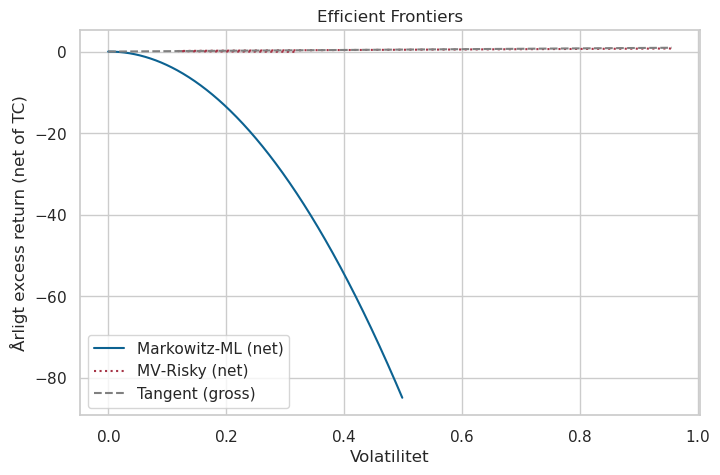

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# Markowitz‐ML (netto)
plt.plot(tpf_ss['sd'], tpf_ss['r_tc'], label="Markowitz‐ML (net)")

# MV‐Risky (netto)
plt.plot(mv_ss['sd'], mv_ss['r_tc'], linestyle=':', label="MV‐Risky (net)")

# Og fx gross tangens‐linje (som før)
slope = tpf_ss['sr_gross'].iloc[1]  # eller genberegn slope
xmax  = max(tpf_ss['sd'].max(), mv_ss['sd'].max())
plt.plot([0, xmax], [0, slope*xmax],
         linestyle='--', color='gray', label="Tangent (gross)")

plt.xlabel("Volatilitet")
plt.ylabel("Årligt excess return (net of TC)")
plt.title("Efficient Frontiers")
plt.legend()
plt.grid(True)
plt.show()


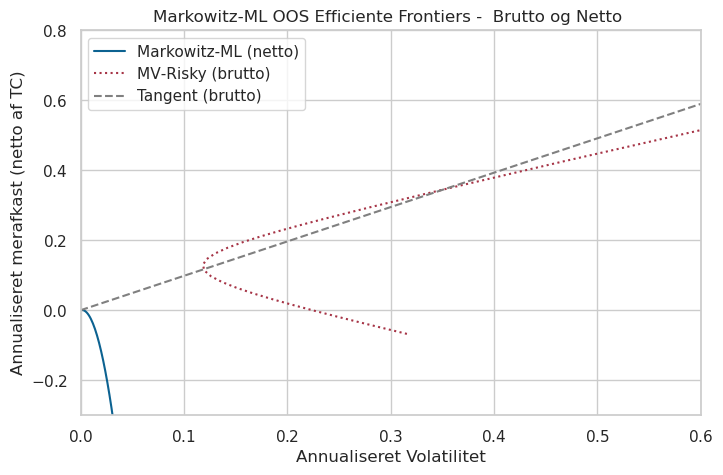

In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# Markowitz‐ML (netto)
plt.plot(tpf_ss['sd'], tpf_ss['r_tc'], label="Markowitz‐ML (netto)")

# MV‐Risky (netto)
plt.plot(mv_ss['sd'], mv_ss['r_tc'], linestyle=':', label="MV‐Risky (brutto)")

# Og fx gross tangens‐linje (som før)
slope = tpf_ss['sr_gross'].iloc[1]  # eller genberegn slope
xmax  = max(tpf_ss['sd'].max(), mv_ss['sd'].max())
plt.plot([0, xmax], [0, slope*xmax],
         linestyle='--', color='gray', label="Tangent (brutto)")

plt.xlabel("Annualiseret Volatilitet")
plt.ylabel("Annualiseret merafkast (netto af TC)")
plt.title("Markowitz-ML OOS Efficiente Frontiers -  Brutto og Netto ")
plt.legend()
plt.grid(True)

# Sæt y‐aksens nedre grænse til -0.2
plt.ylim(-0.3, 0.8)
plt.xlim(0, 0.6)
fig.savefig(
    os.path.join(output_folder, "Markowitz_efficiente_frontiers.png"),
    dpi=300,
    bbox_inches='tight'
)

plt.show()


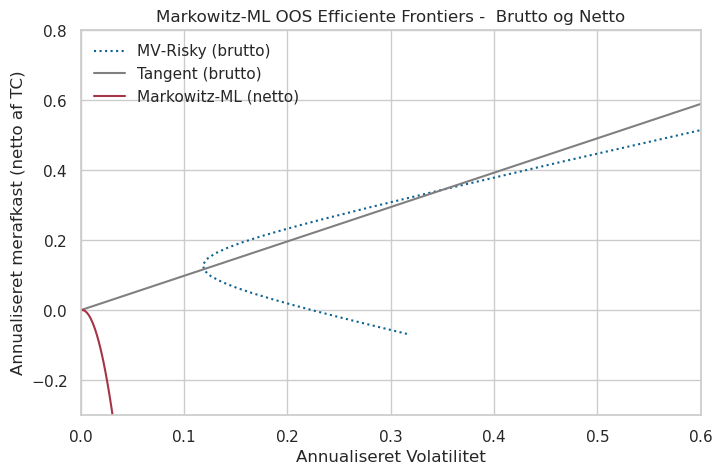

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# 1) Plot i den rækkefølge, du ønsker i legend
# MV‐Risky (brutto)
line1, = plt.plot(mv_ss['sd'], mv_ss['r_tc'], linestyle=':', label="MV‑Risky (brutto)")

# Tangent (brutto)
slope = tpf_ss['sr_gross'].iloc[1]
xmax  = max(tpf_ss['sd'].max(), mv_ss['sd'].max())
line2, = plt.plot([0, xmax], [0, slope*xmax],
                  linestyle='-', color='gray', label="Tangent (brutto)")

# Markowitz‐ML (netto)
line3, = plt.plot(tpf_ss['sd'], tpf_ss['r_tc'], label="Markowitz‑ML (netto)")

plt.xlabel("Annualiseret Volatilitet")
plt.ylabel("Annualiseret merafkast (netto af TC)")
plt.title("Markowitz-ML OOS Efficiente Frontiers -  Brutto og Netto")
plt.grid(True)
plt.ylim(-0.3, 0.8)
plt.xlim(0, 0.6)

# 2) Reorder legend entries (her behøver du egentlig ikke, da du plotted i korrekt rækkefølge)
handles = [line1, line2, line3]
labels  = [h.get_label() for h in handles]

# 3) Placér legend i øverste venstre hjørne
plt.legend(handles, labels, loc='upper left', frameon=False)

# Gem og vis
plt.savefig(os.path.join(output_folder, "Markowitz_efficiente_frontiers.png"),
            dpi=300, bbox_inches='tight')
plt.show()


# Ny version

In [141]:
vol_range = np.arange(0, 0.5, 0.001)
tpf_base = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

In [142]:
# 1) Basal Markowitz-portefølje
tpf_base = portfolio_choice_functions.tpf_implement(
    data=chars,
    cov_list=barra_cov,
    wealth=wealth,
    dates=dates_oos,
    gam=pf_set['gamma_rel']
)

# 2) Annualiseret volatilitet af den basale portefølje
#    svarer til sd(r) * sqrt(12) i R
tpf_base_vol = tpf_base['pf']['r'].std(ddof=1) * np.sqrt(12)

# 3) Efficient frontier for hvert volatilitets‑target
ef_list = []
for vol_target in vol_range:
    scale = vol_target / tpf_base_vol
    # skaler både aktuelle vægte og start‑vægte
    w_scaled = tpf_base['w'].copy()
    w_scaled['w'] *= scale
    w_scaled['w_start'] *= scale

    # kør tidsserie‑funktionen med de skalerede vægte
    pf_ts = pf_ts_fun(
        data=chars,
        wealth=wealth,
        gam=pf_set['gamma_rel'],
        weights=w_scaled
    )
    pf_ts['vol_target'] = vol_target
    ef_list.append(pf_ts)

# 4) Sæt dem sammen til ét DataFrame og tilføj en 'type'-kolonne
tpf_ef = pd.concat(ef_list, ignore_index=True)
tpf_ef['type'] = 'Markowitz-ML'

NameError: name 'pf_ts_fun' is not defined

In [ ]:
tpf_ef

In [88]:
tpf_ef.describe()

,inv,shorting,turnover,r,tc,eom_ret,vol_target
count,72000.000000,72000.000000,72000.000000,72000.000000,72000.000000,72000,72000.000000
mean,8.546535,4.207322,9.360694,0.033469,7.902760,2017-01-14 03:30:00.000000256,0.249500
min,0.000000,0.000000,0.000000,-0.304386,0.000000,2011-01-31 00:00:00,0.000000
25%,3.108603,1.464619,3.390714,-0.000598,0.764482,2014-01-23 06:00:00,0.124750
50%,7.261422,3.475999,7.904073,0.013660,3.828591,2017-01-15 12:00:00,0.249500
75%,12.945129,6.258331,13.858261,0.049008,11.263228,2020-01-07 18:00:00,0.374250
max,36.207838,24.361449,42.809326,0.868232,103.580631,2022-12-31 00:00:00,0.499000
std,6.483266,3.394520,7.242433,0.085150,10.642824,NaN,0.144338


In [93]:
import numpy as np
import pandas as pd
import General_Functions  # Sørg for at have den import

def mv_risky_fun(data, cov_list, wealth, dates, gam, u_vec):
    # 1) Filtrer og gør eom til strings
    data_rel = (
        data.loc[(data["valid"]) & (data["eom"].isin(dates)),
                 ["id", "eom", "me", "tr_ld1", "pred_ld1"]]
            .assign(eom_str=lambda df: pd.to_datetime(df["eom"]).dt.strftime("%Y-%m-%d"))
            .sort_values(["id", "eom"])
    )
    # 2) Split på streng‑nøgle
    data_split = {
        eom: grp.drop(columns="eom_str")
        for eom, grp in data_rel.groupby("eom_str")
    }

    weight_records = []
    for d in dates:
        d_str = pd.to_datetime(d).strftime("%Y-%m-%d")
        if d_str not in data_split:
            print(f"Advarsel: Ingen data for dato {d_str}")
            continue
        data_sub = data_split[d_str]
        ids = data_sub["id"].astype(str).tolist()

        # >>> Her er den vigtige ændring:
        # Byg Sigma med jeres create_cov, ikke med reindex på et dict
        Sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
        Sigma_inv = np.linalg.inv(Sigma)

        er   = data_sub["pred_ld1"].values
        ones = np.ones_like(er)

        a = er.T @ Sigma_inv @ er
        b_sum = float((Sigma_inv @ er).sum())
        c_sum = float((Sigma_inv @ ones).sum())
        denom = a * c_sum - b_sum**2

        for u in u_vec:
            w = ((c_sum*u - b_sum)/denom) * (Sigma_inv @ er) \
              + ((a - b_sum*u)/denom) * (Sigma_inv @ ones)
            weight_records.append(pd.DataFrame({
                "id": data_sub["id"].values,
                "eom": d_str,
                "u": u * 12,
                "w": w
            }))

    mv_opt_all = pd.concat(weight_records, ignore_index=True)

    # 4) Byg porteføljer
    results = []
    for u_sel in mv_opt_all["u"].unique():
        w_opt = mv_opt_all[mv_opt_all["u"] == u_sel][["id", "eom", "w"]].copy()
        weights = portfolio_choice_functions.w_fun(data_rel, dates, w_opt, wealth)
        portf   = portfolio_choice_functions.pf_ts_fun(weights, data, wealth, gam)
        portf["u"] = u_sel
        results.append(portf)

    return pd.concat(results, ignore_index=True)


In [96]:
tpf_mv_risky = mv_risky_fun(
    data=chars,
    cov_list=barra_cov,
    wealth=wealth,
    dates=dates_oos,
    gam=pf_set['gamma_rel'],
    u_vec=u_vec     # fx en liste af månedlige risk‐targets
)


In [95]:
import numpy as np
import pandas as pd
import General_Functions
import portfolio_choice_functions

def mv_risky_fun(data, cov_list, wealth, dates, gam, u_vec):
    """
    Beregn mean-variance effektive porteføljer af risky assets.
    Sørger for, at eom er datetime i både data og resultater, så merges i w_fun virker.
    """

    # 0) Copy og konverter eom til datetime
    data = data.copy()
    data['eom'] = pd.to_datetime(data['eom'])

    # 1) Filtrér kun gyldige observationer på de ønskede måneder
    mask = (data['valid'] == True) & (data['eom'].isin(pd.to_datetime(dates)))
    data_rel = (
        data.loc[mask, ['id', 'eom', 'me', 'tr_ld1', 'pred_ld1']]
            .sort_values(['id', 'eom'])
    )

    # 2) Tilføj streng‑version af eom til split
    data_rel['eom_str'] = data_rel['eom'].dt.strftime('%Y-%m-%d')

    # 3) Split per måned på strengnøgle
    data_split = {
        eom_str: grp.drop(columns='eom_str')
        for eom_str, grp in data_rel.groupby('eom_str')
    }

    weight_records = []

    for d in dates:
        # Sørg for datetime + streng-nøgle
        d_dt = pd.to_datetime(d)
        d_str = d_dt.strftime('%Y-%m-%d')

        if d_str not in data_split:
            print(f"Advarsel: Ingen data for dato {d_str}")
            continue

        data_sub = data_split[d_str]
        ids = data_sub['id'].astype(str).tolist()

        # Hent og invertér kovarians-matricen
        Sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
        Sigma_inv = np.linalg.inv(Sigma)

        # Forventede afkast og enere
        er = data_sub['pred_ld1'].values
        ones = np.ones_like(er)

        # Beregn a, b, c og d
        a = er.T @ Sigma_inv @ er
        b_sum = float((Sigma_inv @ er).sum())
        c_sum = float((Sigma_inv @ ones).sum())
        denom = a * c_sum - b_sum**2

        # Loop over risk‑targets
        for u in u_vec:
            w = ((c_sum*u - b_sum)/denom) * (Sigma_inv @ er) \
              + ((a - b_sum*u)/denom) * (Sigma_inv @ ones)

            weight_records.append(pd.DataFrame({
                'id': data_sub['id'].values,
                'eom': d_dt,          # hold eom som datetime
                'u': u * 12,          # årlig basis
                'w': w
            }))

    # 4) Saml alle vægt‐DataFrames
    mv_opt_all = pd.concat(weight_records, ignore_index=True)

    # 5) Byg porteføljer for hver unik u
    results = []
    for u_sel in mv_opt_all['u'].unique():
        w_opt = mv_opt_all[mv_opt_all['u'] == u_sel][['id', 'eom', 'w']].copy()
        # Nu matcher dtype for eom, så merge i w_fun ikke fejler
        weights = portfolio_choice_functions.w_fun(data_rel, dates, w_opt, wealth)
        portf   = portfolio_choice_functions.pf_ts_fun(weights, data, wealth, gam)
        portf['u'] = u_sel
        results.append(portf)

    return pd.concat(results, ignore_index=True)


# Eksempel på kald:
# tpf_mv_risky = mv_risky_fun(
#     data=chars,
#     cov_list=barra_cov,
#     wealth=wealth,
#     dates=dates_oos,
#     gam=pf_set['gamma_rel'],
#     u_vec=u_vec
# )


In [103]:
tpf_mv_risky

,inv,shorting,turnover,r,tc,eom_ret,u
0,10.818644,4.909322,11.028869,-0.072167,5.527381,2011-01-31,-0.5
1,17.534707,8.267353,15.173210,-0.050769,10.647691,2011-02-28,-0.5
2,10.647667,4.823833,14.400300,-0.038365,9.835904,2011-03-31,-0.5
3,12.448513,5.724256,10.162252,0.021435,4.809190,2011-04-30,-0.5
4,5.919639,2.459820,10.277123,0.023961,4.520354,2011-05-31,-0.5
...,...,...,...,...,...,...,...
3451,141.854190,70.427095,117.481856,0.264319,1308.882166,2022-08-31,2.0
3452,192.004347,95.502174,129.923191,-0.644345,2350.042308,2022-09-30,2.0
3453,36.338731,17.669365,168.718330,0.287606,2738.118160,2022-10-31,2.0
3454,76.887227,37.943613,61.039993,-0.278536,343.745077,2022-11-30,2.0


In [104]:
tpf_mv_risky['r'].std()*np.sqrt(12)

0.9306590243375383

In [105]:
tpf_mv_risky.describe()

,inv,shorting,turnover,r,tc,eom_ret,u
count,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456,3456.000000
mean,30.073670,14.536835,40.782476,-0.043630,225.048829,2017-01-14 03:29:59.999999744,0.160417
min,2.216256,0.608128,1.625098,-3.617036,0.115219,2011-01-31 00:00:00,-0.500000
25%,9.076100,4.038050,15.710950,-0.050999,14.100285,2014-01-23 06:00:00,-0.212500
50%,19.420270,9.210135,29.831548,0.003878,49.597280,2017-01-15 12:00:00,0.075000
75%,37.767791,18.383895,53.414488,0.042534,185.906899,2020-01-07 18:00:00,0.362500
max,322.618761,160.809381,301.779334,1.297470,5920.278029,2022-12-31 00:00:00,2.000000
std,32.441470,16.220735,37.517078,0.268658,488.068302,NaN,0.539364


In [100]:
gamma = pf_set['gamma_rel']

# Funktion, der laver én række med alle de nøgletal, du har i R
def summarize_group(df):
    mean_r     = df['r'].mean()
    std_r      = df['r'].std(ddof=1)
    mean_tc    = df['tc'].mean()
    var_r      = df['r'].var(ddof=1)
    mean_turn  = df['turnover'].mean()
    mean_inv   = df['inv'].mean()
    
    return pd.Series({
        'n'        : len(df),                           # antal observationer
        'inv'      : mean_inv,                          # gennemsnitlig inv
        'to'       : mean_turn,                         # gennemsnitlig turnover
        'r'        : mean_r * 12,                       # annualiseret afkast
        'sd'       : std_r * np.sqrt(12),               # annualiseret sd
        'sr_gross' : mean_r / std_r * np.sqrt(12),       # gross Sharpe
        'tc'       : mean_tc * 12,                      # annualiseret trans.cost
        'r_tc'     : (mean_r - mean_tc) * 12,           # afkast net of tc
        'sr'       : (mean_r - mean_tc) / std_r * np.sqrt(12),  # net Sharpe
        'obj'      : (mean_r - 0.5 * var_r * gamma - mean_tc) * 12
    })

# Anvend funktionen per gruppe
mv_ss = (
    tpf_mv_risky
    .groupby('u')
    .apply(summarize_group)
    .reset_index()
)

print(mv_ss)

               u      n        inv         to         r        sd  sr_gross  \
0  -5.000000e-01  144.0  35.609699  45.520553 -0.972287  1.013010 -0.959800   
1  -4.500000e-01  144.0  33.892245  44.063164 -0.938314  0.988946 -0.948802   
2  -4.000000e-01  144.0  32.293875  42.669541 -0.904341  0.966040 -0.936132   
3  -3.500000e-01  144.0  30.824712  41.342174 -0.870368  0.944374 -0.921635   
4  -3.000000e-01  144.0  29.439910  40.080196 -0.836395  0.924037 -0.905153   
5  -2.500000e-01  144.0  28.134293  38.890731 -0.802422  0.905118 -0.886539   
6  -2.000000e-01  144.0  26.892582  37.784439 -0.768450  0.887708 -0.865656   
7  -1.500000e-01  144.0  25.740298  36.779898 -0.734477  0.871896 -0.842390   
8  -1.000000e-01  144.0  24.710387  35.894635 -0.700504  0.857772 -0.816655   
9  -5.000000e-02  144.0  23.812385  35.152401 -0.666531  0.845419 -0.788403   
10 -1.110223e-16  144.0  23.091023  34.574245 -0.632558  0.834918 -0.757629   
11  5.000000e-02  144.0  22.532585  34.149883 -0.598

C:\Users\jonas\AppData\Local\Temp\ipykernel_17004\1630941035.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [101]:
import numpy as np
import pandas as pd

# Antag at din DataFrame hedder tpf_mv_risky og
# at din risk‑aversion ligger i pf_set['gamma_rel']

gamma = pf_set['gamma_rel']

# 1) Først gør vi en standard .groupby('u') og beregner 
#    de rå statistikker: størrelse, gennemsnit og std af r og tc.
base = tpf_mv_risky.groupby('u').agg(
    n        = ('r',       'size' ),   # .N
    inv      = ('inv',     'mean' ),   # mean(inv)
    to       = ('turnover','mean' ),   # mean(turnover)
    mean_r   = ('r',       'mean' ),   # mean(r)
    sd_r     = ('r',       'std'  ),   # sd(r)
    mean_tc  = ('tc',      'mean' ),   # mean(tc)
).reset_index()

# 2) Så laver vi alle de annualiseringer og Sharpe‑ratio’er
mv_ss = base.assign(
    r        = lambda df: df['mean_r']   * 12,                 # mean(r)*12
    sd       = lambda df: df['sd_r']      * np.sqrt(12),       # sd(r)*√12
    sr_gross = lambda df: df['mean_r']    / df['sd_r']   * np.sqrt(12),  # gross Sharpe
    tc       = lambda df: df['mean_tc']   * 12,                 # mean(tc)*12
    r_tc     = lambda df: (df['mean_r'] - df['mean_tc']) * 12,  # mean(r-tc)*12
    sr       = lambda df: (df['mean_r'] - df['mean_tc']) / df['sd_r'] * np.sqrt(12),  # net Sharpe
    obj      = lambda df: (df['mean_r'] - 0.5 * (df['sd_r']**2) * gamma - df['mean_tc']) * 12
)[['u','n','inv','to','r','sd','sr_gross','tc','r_tc','sr','obj']]

print(mv_ss)


               u    n        inv         to         r        sd  sr_gross  \
0  -5.000000e-01  144  35.609699  45.520553 -0.972287  1.013010 -0.959800   
1  -4.500000e-01  144  33.892245  44.063164 -0.938314  0.988946 -0.948802   
2  -4.000000e-01  144  32.293875  42.669541 -0.904341  0.966040 -0.936132   
3  -3.500000e-01  144  30.824712  41.342174 -0.870368  0.944374 -0.921635   
4  -3.000000e-01  144  29.439910  40.080196 -0.836395  0.924037 -0.905153   
5  -2.500000e-01  144  28.134293  38.890731 -0.802422  0.905118 -0.886539   
6  -2.000000e-01  144  26.892582  37.784439 -0.768450  0.887708 -0.865656   
7  -1.500000e-01  144  25.740298  36.779898 -0.734477  0.871896 -0.842390   
8  -1.000000e-01  144  24.710387  35.894635 -0.700504  0.857772 -0.816655   
9  -5.000000e-02  144  23.812385  35.152401 -0.666531  0.845419 -0.788403   
10 -1.110223e-16  144  23.091023  34.574245 -0.632558  0.834918 -0.757629   
11  5.000000e-02  144  22.532585  34.149883 -0.598585  0.826337 -0.724384   

In [102]:
tpf_base

{'w':            id        eom   w_start         w    tr_ld1    mu_ld1
 0       10032 2010-12-31  0.000115  0.005450       NaN       NaN
 1       10032 2011-01-31  0.004670 -0.000712 -0.126016  0.020052
 2       10032 2011-02-28 -0.000797 -0.018237  0.162330  0.038821
 3       10032 2011-03-31 -0.020276 -0.022771  0.115528  0.003383
 4       10032 2011-04-30 -0.023063 -0.039262  0.040834  0.027662
 ...       ...        ...       ...       ...       ...       ...
 102047  92655 2022-07-31 -0.003641  0.002503  0.055684  0.093630
 102048  92655 2022-08-31  0.002484  0.034401 -0.043528 -0.036188
 102049  92655 2022-09-30  0.036938  0.105128 -0.024368 -0.091370
 102050  92655 2022-10-31  0.106824  0.035075  0.098793  0.081350
 102051  92655 2022-11-30  0.032900  0.007647 -0.013868  0.051329
 
 [102052 rows x 6 columns],
 'pf':            inv   shorting   turnover         r          tc    eom_ret  \
 0    51.580017  25.441835  51.485122  0.138922  112.720683 2011-01-31   
 1    51.442521  24

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Prepare_Data import wealth_func
import portfolio_choice_functions
from General_Functions import create_cov


# Start‐wealth som i R
wealth_0 = wealth_func(
    wealth_end = 0,
    end        = settings['split']['test_end'],
    market     = market,
    risk_free  = risk_free
)

# --- 2) Den rettede mv_risky_fun: ---
def mv_risky_fun(data, cov_list, wealth, dates, gamm, u_vec):
    # 2.1) Tag kun de kolonner, du faktisk bruger for at lave cov og er
    data_rel = (
        data.loc[data["valid"] & data["eom"].isin(dates),
                 ["id","eom","pred_ld1"]]  # fjern turnover, tc, r her
        .sort_values(["id","eom"])
    )

    # 2.2) For hver dato bygges kov.mat og optimale weights
    mv_opt_all = []
    for d in dates:
        sub = data_rel.loc[data_rel["eom"] == d]
        ids = sub["id"].astype(str).tolist()

        sigma     = create_cov(cov_list[str(d)], ids=ids)
        inv_sigma = np.linalg.inv(sigma)

        er   = sub["pred_ld1"].values
        ones = np.ones_like(er)

        a = er @ inv_sigma @ er
        b = inv_sigma @ er
        c = inv_sigma @ ones
        D = a * c.sum() - (b.sum())**2

        for u in u_vec:
            w = ((c.sum()*u - b.sum())/D) * (inv_sigma @ er) + \
                ((a - b.sum()*u)/D) * (inv_sigma @ ones)

            mv_opt_all.append(pd.DataFrame({
                "id"  : sub["id"].values,
                "eom" : d,
                "u"   : u * 12,   # annualiser u
                "w"   : w
            }))

    mv_all = pd.concat(mv_opt_all, ignore_index=True)

    # 2.3) Tilbage­test for hver u med w_fun -> pf_ts_fun
    results = []
    for u_sel in sorted(mv_all["u"].unique()):
        w_sel   = mv_all[mv_all["u"] == u_sel]
        weights = portfolio_choice_functions.w_fun(data_rel, dates, w_sel, wealth)
        pf      = portfolio_choice_functions.pf_ts_fun(
                      weights, chars, wealth, gamm
                  )
        pf["u"] = u_sel
        results.append(pf)

    return pd.concat(results, ignore_index=True)


# --- 3) Byg Markowitz‐ML frontier (tpf_ss) som før ---
tpf_base = portfolio_choice_functions.tpf_implement(
    data=chars, cov_list=barra_cov,
    wealth=wealth_0, dates=dates_oos,
    gam=pf_set["gamma_rel"]
)
base_vol = tpf_base['pf']['r'].std(ddof=1) * np.sqrt(12)

ef_list = []
for vol_t in np.arange(0, 0.5, 0.001):
    scale    = vol_t / base_vol
    w_scaled = tpf_base['w'].copy()
    w_scaled[['w','w_start']] *= scale

    pf_res = portfolio_choice_functions.pf_ts_fun(
        w_scaled, chars, wealth_0, pf_set["gamma_rel"]
    )
    pf_res['vol_target'] = vol_t
    ef_list.append(pf_res)

tpf_ef = pd.concat(ef_list, ignore_index=True)

def summarize_tpf(g):
    r  = g['r']; tc = g.get('tc', 0.0)
    return pd.Series({
        'r'        : r.mean()*12,
        'sd'       : r.std(ddof=1)*np.sqrt(12),
        'sr_gross' : (r.mean()/r.std(ddof=1))*np.sqrt(12),
        'r_tc'     : (r-tc).mean()*12
    })

tpf_ss = (
    tpf_ef
    .groupby('vol_target')
    .apply(summarize_tpf)
    .reset_index()
)


# --- 4) Byg MV‐Risky frontier (mv_ss) uden TC hvis du vil ---
u_vec = np.concatenate([np.arange(-0.5,0.51,0.05), [0.6,0.75,1,2]])/12

mv_res = mv_risky_fun(
    data     = chars,
    cov_list = barra_cov,
    wealth   = wealth_0,
    dates    = dates_oos,
    gamm     = pf_set["gamma_rel"],
    u_vec    = u_vec
)

def summarize_mv(g):
    r  = g['r']; tc = g['tc']
    return pd.Series({
        'r'    : r.mean()*12,
        'sd'   : r.std(ddof=1)*np.sqrt(12),
        'r_tc' : (r-tc).mean()*12,
        'sr_gross': (r.mean()/r.std(ddof=1))*np.sqrt(12)
    })

mv_ss = (
    mv_res
    .groupby('u')
    .apply(summarize_mv)
    .reset_index()
)


# --- 5) Tegn begge fronter + gross‐tangentlinje ---
plt.figure(figsize=(8,5))
plt.plot(tpf_ss['sd'],  tpf_ss['r_tc'],  label="Markowitz-ML (net)", color="blue")
plt.plot(mv_ss['sd'],   mv_ss['r_tc'],   linestyle=':', label="MV-Risky (net)", color="red")

# Gross CML from max gross‐Sharpe
slope = tpf_ss['sr_gross'].max()
xmax  = max(tpf_ss['sd'].max(), mv_ss['sd'].max())
plt.plot([0, xmax], [0, slope*xmax],
         linestyle='--', color='gray', label="Tangent (gross)")

plt.xlabel("Volatilitet")
plt.ylabel("Årligt excess return (net of TC)")
plt.title("Efficient Frontiers")
plt.legend(); plt.grid(True); plt.ylim(-2.2,5)
plt.show()


C:\Users\jonas\AppData\Local\Temp\ipykernel_17004\104465045.py:97: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\jonas\AppData\Local\Temp\ipykernel_17004\104465045.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


KeyError: '2010-12-31 00:00:00'

In [ ]:
import numpy as np
import pandas as pd
import General_Functions  # Sørg for at have den import

def mv_risky_fun(data, cov_list, wealth, dates, gam, u_vec):
    # 1) Filtrer og gør eom til strings
    data_rel = (
        data.loc[(data["valid"]) & (data["eom"].isin(dates)),
                 ["id", "eom", "me", "tr_ld1", "pred_ld1"]]
            .assign(eom_str=lambda df: pd.to_datetime(df["eom"]).dt.strftime("%Y-%m-%d"))
            .sort_values(["id", "eom"])
    )
    # 2) Split på streng‑nøgle
    data_split = {
        eom: grp.drop(columns="eom_str")
        for eom, grp in data_rel.groupby("eom_str")
    }

    weight_records = []
    for d in dates:
        d_str = pd.to_datetime(d).strftime("%Y-%m-%d")
        if d_str not in data_split:
            print(f"Advarsel: Ingen data for dato {d_str}")
            continue
        data_sub = data_split[d_str]
        ids = data_sub["id"].astype(str).tolist()

        # >>> Her er den vigtige ændring:
        # Byg Sigma med jeres create_cov, ikke med reindex på et dict
        Sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
        Sigma_inv = np.linalg.inv(Sigma)

        er   = data_sub["pred_ld1"].values
        ones = np.ones_like(er)

        a = er.T @ Sigma_inv @ er
        b_sum = float((Sigma_inv @ er).sum())
        c_sum = float((Sigma_inv @ ones).sum())
        denom = a * c_sum - b_sum**2

        for u in u_vec:
            w = ((c_sum*u - b_sum)/denom) * (Sigma_inv @ er) \
              + ((a - b_sum*u)/denom) * (Sigma_inv @ ones)
            weight_records.append(pd.DataFrame({
                "id": data_sub["id"].values,
                "eom": d_str,
                "u": u * 12,
                "w": w
            }))

    mv_opt_all = pd.concat(weight_records, ignore_index=True)

    # 4) Byg porteføljer
    results = []
    for u_sel in mv_opt_all["u"].unique():
        w_opt = mv_opt_all[mv_opt_all["u"] == u_sel][["id", "eom", "w"]].copy()
        weights = portfolio_choice_functions.w_fun(data_rel, dates, w_opt, wealth)
        portf   = portfolio_choice_functions.pf_ts_fun(weights, data, wealth, gam)
        portf["u"] = u_sel
        results.append(portf)

    return pd.concat(results, ignore_index=True)


In [ ]:
# Minimum varians portfølje

In [118]:
mv = portfolio_choice_functions.mv_implement(data=chars, cov_list=barra_cov ,wealth=wealth, dates=dates_oos, pf_set= pf_set)
print(mv['pf']['r'].mean()*12)
print(mv['pf']['r'].std()*np.sqrt(12))

0.12761408199348645
0.11859209716379614


In [136]:
print(tpf['pf']['r'].std(ddof=1) * np.sqrt(12))
print(tpf_base['pf']['r'].std(ddof=1) * np.sqrt(12))

0.9933295004496902
0.9933295004496902


In [137]:
import numpy as np
import pandas as pd

ef_theo = []
for u in u_vec:
    rets = []
    vols = []
    for d in dates_oos:
        d_str = d.strftime('%Y-%m-%d')
        sub   = data_split[d_str]
        ids   = sub['id'].astype(str)
        sigma = General_Functions.create_cov(barra_cov[d_str], ids=ids)
        inv   = np.linalg.inv(sigma)
        er    = sub['pred_ld1'].values
        ones  = np.ones_like(er)
        a = er.T @ inv @ er
        b = inv @ er
        c = inv @ ones
        D = a*c.sum() - (b.sum())**2

        # optimal weights for u (u er allerede i årlig basis, ellers gang med 12)
        w = ((c.sum()*u - b.sum())/D)*(inv@er) + ((a - b.sum()*u)/D)*(inv@ones)

        rets.append(w.T @ er)
        vols.append(np.sqrt(w.T @ sigma @ w))

    ef_theo.append({
        'u'  : u*12,
        'ret': np.mean(rets)*12,
        'vol': np.mean(vols)*np.sqrt(12)
    })

ef_theo = pd.DataFrame(ef_theo)


NameError: name 'data_split' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
# Teoretisk MV‑frontier (out‑of‑sample)
plt.plot(ef_theo['vol'], ef_theo['ret'], label='MV‑Frontier (theoretical)')

# Din backtest-frontier (net)
plt.plot(mv_ss['sd'], mv_ss['r_tc'], linestyle=':', label='MV‑Risky (net)')

# Tangentlinje (brug net‑Sharpe hvis du vil tangere net‑frontier)
slope_net = tpf_ss['sr'].iloc[1]  # net‑Sharpe fra summarize (brug 'sr' ikke 'sr_gross')
xmax = max(ef_theo['vol'].max(), mv_ss['sd'].max())
plt.plot([0, xmax], [0, slope_net*xmax],
         linestyle='--', color='gray', label='Tangent (net)')

plt.xlabel("Volatilitet")
plt.ylabel("Årligt excess return (net of TC)")
plt.title("Efficient Frontier Out‑of‑Sample")
plt.legend()
plt.grid(True)
plt.ylim(-1.2,1)
plt.xlim(0,1.2)
plt.show()


In [138]:
# 0) Byg data_split præcis som i mv_risky_fun
data_rel = chars.loc[
    (chars["valid"]) & (chars["eom"].isin(dates_oos)),
    ["id", "eom", "pred_ld1"]
].copy()
data_rel = data_rel.sort_values(["id", "eom"])

data_split = {}
for eom_val, grp in data_rel.groupby("eom"):
    if hasattr(eom_val, "strftime"):
        key = eom_val.strftime("%Y-%m-%d")
    else:
        key = str(eom_val)
    data_split[key] = grp.copy()


In [139]:
ef_theo = []
for u in u_vec:
    rets, vols = [], []
    for d in dates_oos:
        d_str = d.strftime("%Y-%m-%d")
        sub   = data_split[d_str]          # nu defineret!
        ids   = sub["id"].astype(str)
        sigma = General_Functions.create_cov(barra_cov[d_str], ids=ids)
        inv   = np.linalg.inv(sigma)
        er    = sub["pred_ld1"].values
        ones  = np.ones_like(er)

        a = er.T @ inv @ er
        b = inv @ er
        c = inv @ ones
        D = a*c.sum() - (b.sum())**2

        w = ((c.sum()*u - b.sum())/D)*(inv@er) + ((a - b.sum()*u)/D)*(inv@ones)

        rets.append(w.T @ er)
        vols.append(np.sqrt(w.T @ sigma @ w))

    ef_theo.append({
        "u"  : u*12,
        "ret": np.mean(rets)*12,
        "vol": np.mean(vols)*np.sqrt(12)
    })

ef_theo = pd.DataFrame(ef_theo)


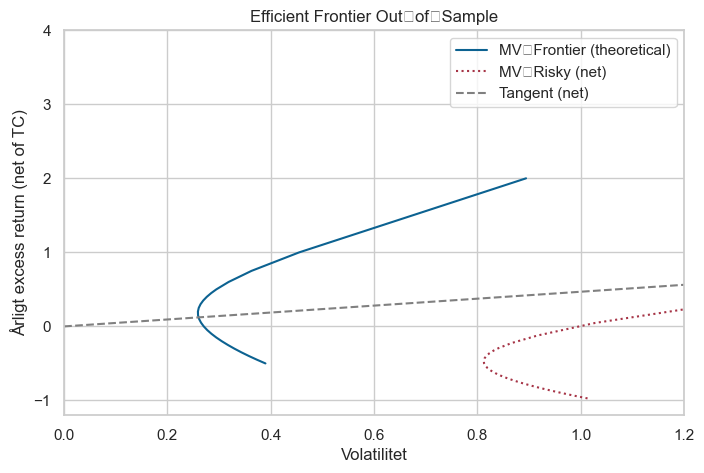

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
# Teoretisk MV‑frontier (out‑of‑sample)
plt.plot(ef_theo['vol'], ef_theo['ret'], label='MV‑Frontier (theoretical)')

# Din backtest-frontier (net)
plt.plot(mv_ss['sd'], mv_ss['r_tc'], linestyle=':', label='MV‑Risky (net)')

# Tangentlinje (brug net‑Sharpe hvis du vil tangere net‑frontier)
slope_net = tpf_ss['sr'].iloc[1]  # net‑Sharpe fra summarize (brug 'sr' ikke 'sr_gross')
xmax = max(ef_theo['vol'].max(), mv_ss['sd'].max())
plt.plot([0, xmax], [0, slope_net*xmax],
         linestyle='--', color='gray', label='Tangent (net)')

plt.xlabel("Volatilitet")
plt.ylabel("Årligt excess return (net of TC)")
plt.title("Efficient Frontier Out‑of‑Sample")
plt.legend()
plt.grid(True)
plt.ylim(-1.2,4)
plt.xlim(0,1.2)
plt.show()


C:\Users\jonas\anaconda3\envs\fin_econ_2024\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.


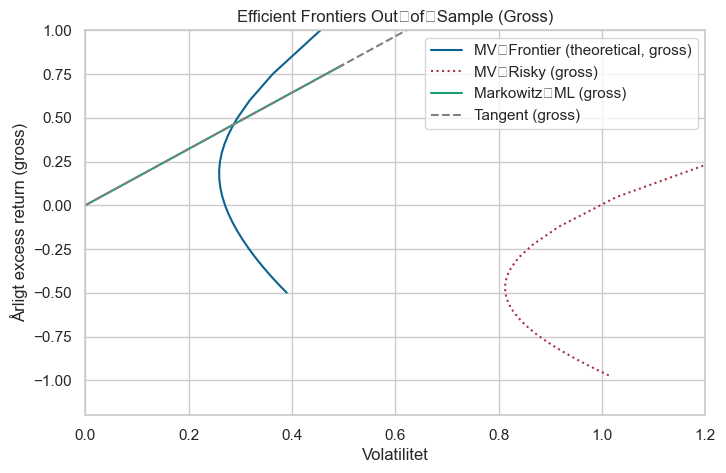

In [142]:
data_rel = chars.loc[
    (chars["valid"]) & (chars["eom"].isin(dates_oos)),
    ["id", "eom", "pred_ld1"]
].copy()
data_rel = data_rel.sort_values(["id", "eom"])

data_split = {}
for eom_val, grp in data_rel.groupby("eom"):
    key = eom_val.strftime("%Y-%m-%d") if hasattr(eom_val, "strftime") else str(eom_val)
    data_split[key] = grp.copy()

# 7) Beregn teoretisk MV‑frontier (gross) på tværs af u_vec
ef_theo = []
for u in u_vec:
    rets, vols = [], []
    for d in dates_oos:
        d_str = d.strftime("%Y-%m-%d")
        sub   = data_split[d_str]
        ids   = sub["id"].astype(str)
        sigma = General_Functions.create_cov(barra_cov[d_str], ids=ids)
        inv   = np.linalg.inv(sigma)
        er    = sub["pred_ld1"].values
        ones  = np.ones_like(er)

        a = er.T @ inv @ er
        b = inv @ er
        c = inv @ ones
        D = a * c.sum() - (b.sum())**2

        w = ((c.sum()*u - b.sum())/D)*(inv@er) + ((a - b.sum()*u)/D)*(inv@ones)

        rets.append(w.T @ er)
        vols.append(np.sqrt(w.T @ sigma @ w))

    ef_theo.append({
        "u"  : u*12,
        "ret": np.mean(rets)*12,
        "vol": np.mean(vols)*np.sqrt(12)
    })
ef_theo = pd.DataFrame(ef_theo)


# 8) Plot alle tre frontiers (gross) + gross tangent
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# Teoretisk MV‑frontier (gross)
plt.plot(ef_theo['vol'], ef_theo['ret'],
         label='MV‑Frontier (theoretical, gross)')

# Backtested MV‑Risky (gross)
plt.plot(mv_ss['sd'], mv_ss['r'],
         linestyle=':', label='MV‑Risky (gross)')

# Markowitz‑ML (gross)
plt.plot(tpf_ss['sd'], tpf_ss['r'],
         label='Markowitz‑ML (gross)')

# Tangentlinje (gross Sharpe)
slope_gross = tpf_ss['sr_gross'].max()   # eller tpf_ss['sr_gross'].iloc[1]
xmax = max(ef_theo['vol'].max(), mv_ss['sd'].max(), tpf_ss['sd'].max())
plt.plot([0, xmax], [0, slope_gross * xmax],
         linestyle='--', color='gray',
         label='Tangent (gross)')

plt.xlabel("Volatilitet")
plt.ylabel("Årligt excess return (gross)")
plt.title("Efficient Frontiers Out‑of‑Sample (Gross)")
plt.legend()
plt.grid(True)
plt.ylim(-1.2, 1)
plt.xlim(0, 1.2)
plt.show()

# Portfoli-ML IEF med wealth 1e10

In [32]:
wealth_strs = ["1e10"]
gamma_vals  = [1, 5, 10, 20, 100]
# Hardcoded liste over præcise filnavne, her variereres gamma kun
files = [
    "pfml_seed_10_NEW_WEALTH1e10_GAMMA1.pkl",
    #"pfml_seed_10_NEW_WEALTH1e10_GAMMA2.pkl",
    #"pfml_seed_10_NEW_WEALTH1e10_GAMMA3.pkl",
    "pfml_seed_10_NEW_WEALTH1e10_GAMMA5.pkl",
    "pfml_seed_10_NEW_WEALTH1e10_GAMMA10.pkl",
    "pfml_seed_10_NEW_WEALTH1e10_GAMMA20.pkl",
    "pfml_seed_10_NEW_WEALTH1e10_GAMMA100.pkl",
]

# ========== Load & merge ==========
dfs = []
for fname in files:
    path = os.path.join(folder_name, fname)
    if not os.path.isfile(path):
        print(f"Advarsel: {fname} findes ikke.")
        continue

    # Load pickle
    with open(path, "rb") as f:
        obj = pickle.load(f)

    # Find selve DataFrame'en
    if isinstance(obj, pd.DataFrame):
        pf = obj
    elif hasattr(obj, "pf"):
        pf = obj.pf
    elif isinstance(obj, dict) and "pf" in obj:
        pf = obj["pf"]
    else:
        raise ValueError(f"Kunne ikke finde pf i {fname}")

    # Strip ".pkl" før regex
    base = os.path.splitext(fname)[0]

    # Stram regex: fang kun tal, evt. videnskabelig notation
    w_str = re.search(r"WEALTH([0-9eE.+-]+)(?=_GAMMA)", base).group(1)
    g_str = re.search(r"GAMMA([0-9eE.+-]+)$",           base).group(1)

    w = float(w_str)
    g = float(g_str)

    # Tilføj metadata
    pf = pf.assign(
        wealth_end = w,
        gamma_rel  = g,
        type       = "Portfolio-ML"
    )

    dfs.append(pf)

# Sammensæt alt i ét DataFrame
ief_pfs = pd.concat(dfs, ignore_index=True)

In [33]:
ief_pfs

,inv,shorting,turnover,r,tc,eom_ret,type,wealth_end,gamma_rel
0,0.899555,0.000457,0.173892,0.019516,0.000133,2011-01-31,Portfolio-ML,1.000000e+10,1.0
1,0.870174,0.000775,0.127178,0.030953,0.000092,2011-02-28,Portfolio-ML,1.000000e+10,1.0
2,0.868407,0.003168,0.098995,0.006608,0.000061,2011-03-31,Portfolio-ML,1.000000e+10,1.0
3,0.893629,0.011748,0.095261,0.026909,0.000062,2011-04-30,Portfolio-ML,1.000000e+10,1.0
4,0.922269,0.017311,0.077061,-0.007892,0.000048,2011-05-31,Portfolio-ML,1.000000e+10,1.0
...,...,...,...,...,...,...,...,...,...
715,0.125559,0.044060,0.025648,-0.001224,0.000009,2022-08-31,Portfolio-ML,1.000000e+10,100.0
716,0.125656,0.042841,0.022239,-0.002096,0.000008,2022-09-30,Portfolio-ML,1.000000e+10,100.0
717,0.125216,0.043126,0.019424,0.004601,0.000006,2022-10-31,Portfolio-ML,1.000000e+10,100.0
718,0.125320,0.043917,0.019195,0.002846,0.000007,2022-11-30,Portfolio-ML,1.000000e+10,100.0


In [34]:
# Tjek for dubletter (wealth_end, gamma_rel, type, eom_ret)
dups = (
    ief_pfs
    .groupby(["wealth_end","gamma_rel","type","eom_ret"])
    .size()
    .reset_index(name="count")
)
assert (dups["count"] == 1).all(), "Der er dubletter i dine data!"

# ========== Beregn summary-statistikker ==========
def summarize(group):
    gamma = group.name[2]
    r  = group["r"]
    tc = group["tc"]

    return pd.Series({
        "inv"       : group["inv"].mean(),
        "to"        : group["turnover"].mean(),
        "r_annual"  : r.mean() * 12,
        "sd_annual" : r.std()  * np.sqrt(12),
        "sr_gross"  : r.mean() / r.std() * np.sqrt(12),
        "tc_annual" : tc.mean() * 12,
        "r_tc"      : (r - tc).mean() * 12,
        "sr_net"    : (r - tc).mean() / r.std() * np.sqrt(12),
        "obj"       : (r.mean() - 0.5 * r.var() * gamma - tc.mean()) * 12
    })

ef_ss_wealth_1e10 = (
    ief_pfs
    .groupby(["type","wealth_end","gamma_rel"])
    .apply(summarize)
    .reset_index()
)

print(ef_ss_wealth_1e10)

           type    wealth_end  gamma_rel       inv        to  r_annual  \
0  Portfolio-ML  1.000000e+10        1.0  1.873305  0.065899  0.152023   
1  Portfolio-ML  1.000000e+10        5.0  0.970917  0.084698  0.046955   
2  Portfolio-ML  1.000000e+10       10.0  0.521252  0.052083  0.027194   
3  Portfolio-ML  1.000000e+10       20.0  0.262237  0.032893  0.013244   
4  Portfolio-ML  1.000000e+10      100.0  0.131145  0.031245  0.006069   

   sd_annual  sr_gross  tc_annual      r_tc    sr_net       obj  
0   0.228891  0.664171   0.000647  0.151375  0.661344  0.125180  
1   0.058579  0.801569   0.007782  0.039173  0.668717  0.030594  
2   0.035036  0.776179   0.001859  0.025335  0.723130  0.019198  
3   0.017166  0.771531   0.000329  0.012915  0.752340  0.009968  
4   0.005909  1.027171   0.000331  0.005738  0.971094  0.003992  


C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\1248644825.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


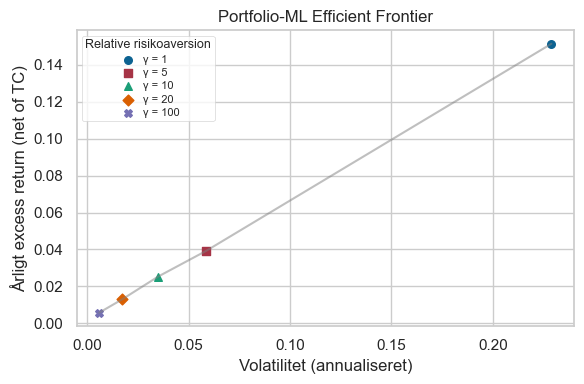

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Antag: ef_ss indeholder kolonnerne 'type','sd_annual','r_tc','gamma_rel'
ef_port = ef_ss_wealth_1e10.loc[ef_ss_wealth_1e10['type'] == "Portfolio-ML"]

marker_map = {
    1:   "o",
    #2:   "+",
    #3:   "x",
    5:   "s",
    10:  "^",
    20:  "D", 
    100: "X", 
}

fig, ax = plt.subplots(figsize=(6, 4))

for gamma, marker in marker_map.items():
    subset = ef_port[ef_port['gamma_rel'] == gamma]
    ax.scatter(
        subset['sd_annual'],
        subset['r_tc'],
        marker=marker,
        s=30,
        label = f"γ = {gamma}"  # eller f"$\\gamma$ = {gamma}"
    )

# Linje imellem punkterne
efs = ef_port.sort_values("sd_annual")
ax.plot(efs['sd_annual'], efs['r_tc'],
        linestyle='-', color='gray', alpha=0.5)

ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("Portfolio-ML Efficient Frontier")

# Gør legend-boxen mindre
leg = ax.legend(
    title="Relative risikoaversion",
    fontsize=8,
    title_fontsize=9,
    borderpad=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    markerscale=1,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

ax.grid(True)
plt.tight_layout()
plt.show()


# Portfolio-ML IEF med wealth 1e9

In [72]:
wealth_strs = ["1e9"]
gamma_vals  = [1, 5, 10, 20, 100]

files = [
    "pfml_seed_10_NEW_WEALTH1e9_GAMMA1.pkl",
    "pfml_seed_10_NEW_WEALTH1e9_GAMMA5.pkl",
    "pfml_seed_10_NEW_WEALTH1e9_GAMMA10.pkl",
    "pfml_seed_10_NEW_WEALTH1e9_GAMMA20.pkl",
    "pfml_seed_10_NEW_WEALTH1e9_GAMMA100.pkl",
]



# ========== Load & merge ==========
dfs = []
for fname in files:
    path = os.path.join(folder_name, fname)
    if not os.path.isfile(path):
        print(f"Advarsel: {fname} findes ikke.")
        continue

    # Load pickle
    with open(path, "rb") as f:
        obj = pickle.load(f)

    # Find selve DataFrame'en
    if isinstance(obj, pd.DataFrame):
        pf = obj
    elif hasattr(obj, "pf"):
        pf = obj.pf
    elif isinstance(obj, dict) and "pf" in obj:
        pf = obj["pf"]
    else:
        raise ValueError(f"Kunne ikke finde pf i {fname}")

    # Strip ".pkl" før regex
    base = os.path.splitext(fname)[0]

    # Stram regex: fang kun tal, evt. videnskabelig notation
    w_str = re.search(r"WEALTH([0-9eE.+-]+)(?=_GAMMA)", base).group(1)
    g_str = re.search(r"GAMMA([0-9eE.+-]+)$",           base).group(1)

    w = float(w_str)
    g = float(g_str)

    # Tilføj metadata
    pf = pf.assign(
        wealth_end = w,
        gamma_rel  = g,
        type       = "Portfolio-ML"
    )

    dfs.append(pf)

# Sammensæt alt i ét DataFrame
ief_pfs = pd.concat(dfs, ignore_index=True)

In [73]:
ief_pfs

,inv,shorting,turnover,r,tc,eom_ret,type,wealth_end,gamma_rel
0,1.508512,0.170114,0.991088,0.024425,0.001124,2011-01-31,Portfolio-ML,1.000000e+09,1.0
1,1.699484,0.228301,0.597485,0.049952,0.000347,2011-02-28,Portfolio-ML,1.000000e+09,1.0
2,1.841884,0.278111,0.399229,0.023325,0.000155,2011-03-31,Portfolio-ML,1.000000e+09,1.0
3,2.039308,0.354173,0.327196,0.055110,0.000118,2011-04-30,Portfolio-ML,1.000000e+09,1.0
4,2.101243,0.371982,0.256619,0.002945,0.000075,2011-05-31,Portfolio-ML,1.000000e+09,1.0
...,...,...,...,...,...,...,...,...,...
715,0.230425,0.092656,0.099739,-0.000968,0.000017,2022-08-31,Portfolio-ML,1.000000e+09,100.0
716,0.226749,0.087798,0.095606,-0.002508,0.000018,2022-09-30,Portfolio-ML,1.000000e+09,100.0
717,0.228776,0.092002,0.080648,0.005669,0.000013,2022-10-31,Portfolio-ML,1.000000e+09,100.0
718,0.222125,0.090248,0.083470,0.003724,0.000014,2022-11-30,Portfolio-ML,1.000000e+09,100.0


In [74]:
# Tjek for dubletter (wealth_end, gamma_rel, type, eom_ret)
dups = (
    ief_pfs
    .groupby(["wealth_end","gamma_rel","type","eom_ret"])
    .size()
    .reset_index(name="count")
)
assert (dups["count"] == 1).all(), "Der er dubletter i dine data!"

# ========== Beregn summary-statistikker ==========
def summarize(group):
    gamma = group.name[2]
    print(gamma)
    r  = group["r"]
    tc = group["tc"]

    return pd.Series({
        "inv"       : group["inv"].mean(),
        "to"        : group["turnover"].mean(),
        "r_annual"  : r.mean() * 12,
        "sd_annual" : r.std()  * np.sqrt(12),
        "sr_gross"  : r.mean() / r.std() * np.sqrt(12),
        "tc_annual" : tc.mean() * 12,
        "r_tc"      : (r - tc).mean() * 12,
        "sr_net"    : (r - tc).mean() / r.std() * np.sqrt(12),
        "obj"       : (r.mean() - 0.5 * r.var() * gamma - tc.mean()) * 12
    })

ef_ss_wealth_1e9 = (
    ief_pfs
    .groupby(["type","wealth_end","gamma_rel"])
    .apply(summarize)
    .reset_index()
)

print(ef_ss_wealth_1e9)

1.0
5.0
10.0
20.0
100.0
           type    wealth_end  gamma_rel       inv        to  r_annual  \
0  Portfolio-ML  1.000000e+09        1.0  5.186093  0.468054  0.275013   
1  Portfolio-ML  1.000000e+09        5.0  2.098668  0.294348  0.103208   
2  Portfolio-ML  1.000000e+09       10.0  1.270098  0.242741  0.060580   
3  Portfolio-ML  1.000000e+09       20.0  0.787619  0.203737  0.035728   
4  Portfolio-ML  1.000000e+09      100.0  0.254195  0.119132  0.010616   

   sd_annual  sr_gross  tc_annual      r_tc    sr_net       obj  
0   0.351325  0.782789   0.017121  0.257892  0.734055  0.196177  
1   0.108399  0.952113   0.003370  0.099838  0.921023  0.070462  
2   0.058284  1.039390   0.001038  0.059542  1.021582  0.042557  
3   0.032636  1.094736   0.001052  0.034676  1.062504  0.024025  
4   0.008918  1.190399   0.000318  0.010298  1.154759  0.006322  


C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\245432325.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


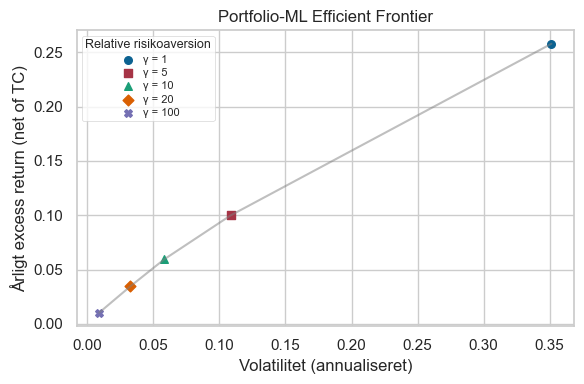

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Antag: ef_ss indeholder kolonnerne 'type','sd_annual','r_tc','gamma_rel'
ef_port = ef_ss_wealth_1e9.loc[ef_ss_wealth_1e9['type'] == "Portfolio-ML"]

marker_map = {
    1:   "o",
    #2:   "+",
    #3:   "x",
    5:   "s",
    10:  "^",
    20:  "D", 
    100: "X", 
}

fig, ax = plt.subplots(figsize=(6, 4))

for gamma, marker in marker_map.items():
    subset = ef_port[ef_port['gamma_rel'] == gamma]
    ax.scatter(
        subset['sd_annual'],
        subset['r_tc'],
        marker=marker,
        s=30,
        label = f"γ = {gamma}"  # eller f"$\\gamma$ = {gamma}"
    )

# Linje imellem punkterne
efs = ef_port.sort_values("sd_annual")
ax.plot(efs['sd_annual'], efs['r_tc'],
        linestyle='-', color='gray', alpha=0.5)

ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("Portfolio-ML Efficient Frontier")

# Gør legend-boxen mindre
leg = ax.legend(
    title="Relative risikoaversion",
    fontsize=8,
    title_fontsize=9,
    borderpad=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    markerscale=1,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

ax.grid(True)
plt.tight_layout()
plt.show()


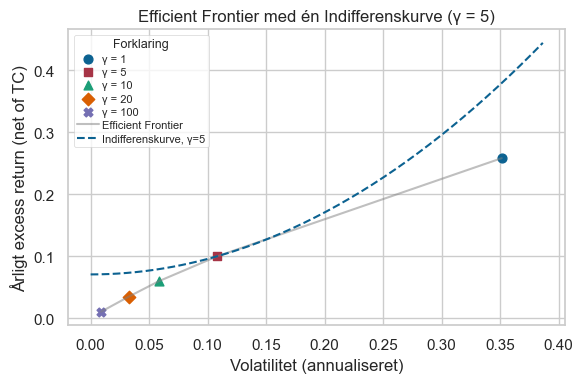

In [79]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# — Antag: ef_ss_wealth_1e9 er allerede defineret som før —
ef_port = ef_ss_wealth_1e9[ef_ss_wealth_1e9['type'] == "Portfolio-ML"]

# Marker‐map som før
marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D",
    100: "X",
}

# — Tegn efficient frontier og punkter —
fig, ax = plt.subplots(figsize=(6, 4))

for gamma, marker in marker_map.items():
    sub = ef_port[ef_port['gamma_rel'] == gamma]
    ax.scatter(
        sub['sd_annual'],
        sub['r_tc'],
        marker=marker,
        s=40,
        label=f"γ = {int(gamma)}"
    )

efs = ef_port.sort_values("sd_annual")
ax.plot(
    efs['sd_annual'], 
    efs['r_tc'],
    linestyle='-',
    color='gray',
    alpha=0.5,
    label="Efficient Frontier"
)

# — Beregn og tegn kun indifferenskurven for γ = 5 —
gamma0 = 5
sub5  = ef_port[ef_port['gamma_rel'] == gamma0]
sigma0 = sub5['sd_annual'].iloc[0]
mu0    = sub5['r_tc'].iloc[0]

# Nytteniveau for γ=5
U0 = mu0 - 0.5 * gamma0 * sigma0**2

# σ‑grid til parabel
sigma_max = ef_port['sd_annual'].max() * 1.1
sigma = np.linspace(0, sigma_max, 200)

# Indifferens‑kurve
mu_curve = U0 + 0.5 * gamma0 * sigma**2
ax.plot(
    sigma,
    mu_curve,
    linestyle='--',
    linewidth=1.5,
    label=f"Indifferenskurve, γ={gamma0}"
)

# — Opsætning af akser, titel, legend og grid —
ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("Efficient Frontier med én Indifferenskurve (γ = 5)")

leg = ax.legend(
    fontsize=8,
    title="Forklaring",
    title_fontsize=9,
    borderpad=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    markerscale=1,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

ax.grid(True)
plt.tight_layout()
plt.show()


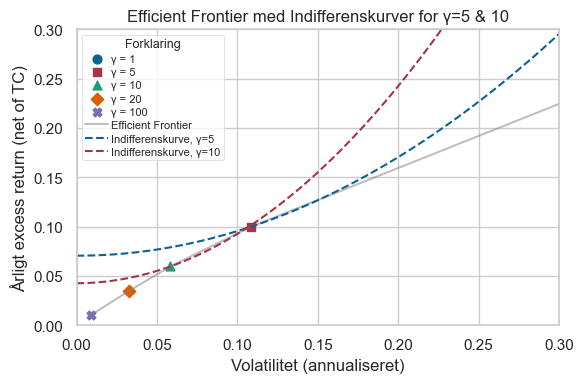

In [81]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# — Antag: ef_ss_wealth_1e9 er allerede defineret som før —
ef_port = ef_ss_wealth_1e9[ef_ss_wealth_1e9['type'] == "Portfolio-ML"]

# Marker‐map som før
marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D",
    100: "X",
}

# Liste over de γ‐værdier, vi vil tegne indifferenskurver for
gamma_list = [5, 10]

# — Plot efficient frontier og punkter —
fig, ax = plt.subplots(figsize=(6, 4))

for gamma, marker in marker_map.items():
    sub = ef_port[ef_port['gamma_rel'] == gamma]
    ax.scatter(
        sub['sd_annual'],
        sub['r_tc'],
        marker=marker,
        s=40,
        label=f"γ = {int(gamma)}"
    )

efs = ef_port.sort_values("sd_annual")
ax.plot(
    efs['sd_annual'], 
    efs['r_tc'],
    linestyle='-',
    color='gray',
    alpha=0.5,
    label="Efficient Frontier"
)

# — Beregn og tegn indifferenskurver for γ = 5 og γ = 10 —
# Lav et volatilitet‐grid
sigma_max = ef_port['sd_annual'].max() * 1.1
sigma = np.linspace(0, sigma_max, 200)

for gamma0 in gamma_list:
    subg = ef_port[ef_port['gamma_rel'] == gamma0]
    sigma0 = subg['sd_annual'].iloc[0]
    mu0    = subg['r_tc'].iloc[0]
    # Nytteniveau
    U0 = mu0 - 0.5 * gamma0 * sigma0**2
    # Indifferens‐kurve
    mu_curve = U0 + 0.5 * gamma0 * sigma**2
    ax.plot(
        sigma,
        mu_curve,
        linestyle='--',
        linewidth=1.5,
        label=f"Indifferenskurve, γ={gamma0}"
    )

# — Opsætning af akser, titel, legend og grid —
ax.set_xlim([0, 0.3]) #Manuelle græsner
ax.set_ylim([0, 0.3]) #Manuelle grænser
ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("Efficient Frontier med Indifferenskurver for γ=5 & 10")

leg = ax.legend(
    fontsize=8,
    title="Forklaring",
    title_fontsize=9,
    borderpad=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    markerscale=1,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

ax.grid(True)
plt.tight_layout()
plt.show()


# Portfolio-ML IEF med wealth 1 (1 dollar :) )

In [164]:
wealth_strs = ["1"]
gamma_vals  = [1, 5, 10, 20, 100]

files = [
    "pfml_seed_10_NEW_WEALTH1_GAMMA5.pkl",
    "pfml_seed_10_NEW_WEALTH1_GAMMA10.pkl",
    "pfml_seed_10_NEW_WEALTH1_GAMMA20.pkl",
]



# ========== Load & merge ==========
dfs = []
for fname in files:
    path = os.path.join(folder_name, fname)
    if not os.path.isfile(path):
        print(f"Advarsel: {fname} findes ikke.")
        continue

    # Load pickle
    with open(path, "rb") as f:
        obj = pickle.load(f)

    # Find selve DataFrame'en
    if isinstance(obj, pd.DataFrame):
        pf = obj
    elif hasattr(obj, "pf"):
        pf = obj.pf
    elif isinstance(obj, dict) and "pf" in obj:
        pf = obj["pf"]
    else:
        raise ValueError(f"Kunne ikke finde pf i {fname}")

    # Strip ".pkl" før regex
    base = os.path.splitext(fname)[0]

    # Stram regex: fang kun tal, evt. videnskabelig notation
    w_str = re.search(r"WEALTH([0-9eE.+-]+)(?=_GAMMA)", base).group(1)
    g_str = re.search(r"GAMMA([0-9eE.+-]+)$",           base).group(1)

    w = float(w_str)
    g = float(g_str)

    # Tilføj metadata
    pf = pf.assign(
        wealth_end = w,
        gamma_rel  = g,
        type       = "Portfolio-ML"
    )

    dfs.append(pf)

# Sammensæt alt i ét DataFrame
ief_pfs = pd.concat(dfs, ignore_index=True)

In [165]:
# Tjek for dubletter (wealth_end, gamma_rel, type, eom_ret)
dups = (
    ief_pfs
    .groupby(["wealth_end","gamma_rel","type","eom_ret"])
    .size()
    .reset_index(name="count")
)
assert (dups["count"] == 1).all(), "Der er dubletter i dine data!"

# ========== Beregn summary-statistikker ==========
def summarize(group):
    gamma = group.name[2]
    print(gamma)
    r  = group["r"]
    tc = group["tc"]

    return pd.Series({
        "inv"       : group["inv"].mean(),
        "to"        : group["turnover"].mean(),
        "r_annual"  : r.mean() * 12,
        "sd_annual" : r.std()  * np.sqrt(12),
        "sr_gross"  : r.mean() / r.std() * np.sqrt(12),
        "tc_annual" : tc.mean() * 12,
        "r_tc"      : (r - tc).mean() * 12,
        "sr_net"    : (r - tc).mean() / r.std() * np.sqrt(12),
        "obj"       : (r.mean() - 0.5 * r.var() * gamma - tc.mean()) * 12
    })

ef_ss_wealth_1e1 = (
    ief_pfs
    .groupby(["type","wealth_end","gamma_rel"])
    .apply(summarize)
    .reset_index()
)

print(ef_ss_wealth_1e1)

5.0
10.0
20.0
           type  wealth_end  gamma_rel       inv        to  r_annual  \
0  Portfolio-ML         1.0        5.0  8.854303  8.296266  0.333817   
1  Portfolio-ML         1.0       10.0  4.480331  4.203543  0.168280   
2  Portfolio-ML         1.0       20.0  2.212716  2.075890  0.083347   

   sd_annual  sr_gross     tc_annual      r_tc    sr_net       obj  
0   0.269049  1.240729  5.629351e-09  0.333817  1.240729  0.152848  
1   0.137187  1.226646  1.425337e-09  0.168280  1.226646  0.074178  
2   0.069047  1.207111  3.474177e-10  0.083347  1.207111  0.035673  


C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\1773398436.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


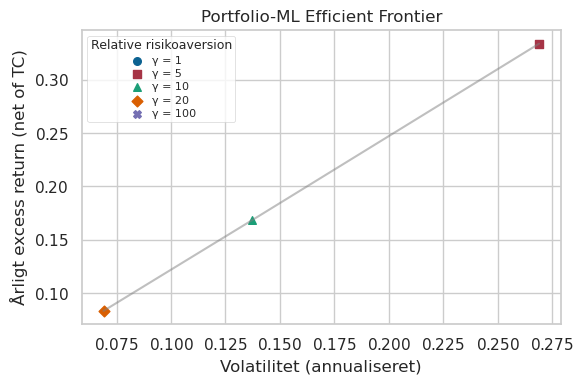

In [166]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Antag: ef_ss indeholder kolonnerne 'type','sd_annual','r_tc','gamma_rel'
ef_port = ef_ss_wealth_1e1.loc[ef_ss_wealth_1e1['type'] == "Portfolio-ML"]

marker_map = {
    1:   "o",
    #2:   "+",
    #3:   "x",
    5:   "s",
    10:  "^",
    20:  "D", 
    100: "X", 
}

fig, ax = plt.subplots(figsize=(6, 4))

for gamma, marker in marker_map.items():
    subset = ef_port[ef_port['gamma_rel'] == gamma]
    ax.scatter(
        subset['sd_annual'],
        subset['r_tc'],
        marker=marker,
        s=30,
        label = f"γ = {gamma}"  # eller f"$\\gamma$ = {gamma}"
    )

# Linje imellem punkterne
efs = ef_port.sort_values("sd_annual")
ax.plot(efs['sd_annual'], efs['r_tc'],
        linestyle='-', color='gray', alpha=0.5)

ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("Portfolio-ML Efficient Frontier")

# Gør legend-boxen mindre
leg = ax.legend(
    title="Relative risikoaversion",
    fontsize=8,
    title_fontsize=9,
    borderpad=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    markerscale=1,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

ax.grid(True)
plt.tight_layout()
plt.show()


#Vi tvinger den lige til at gå igennem 0.0

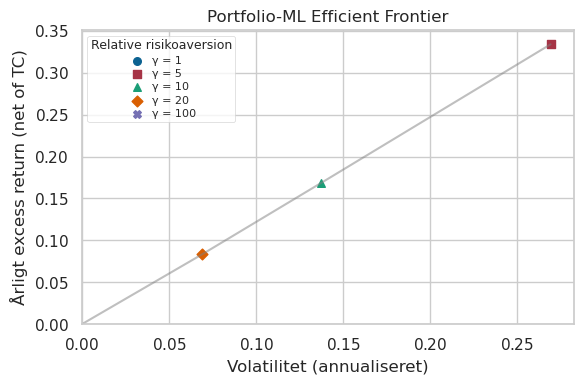

In [167]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Antag: ef_ss_wealth_1e1 indeholder kolonnerne 'type','sd_annual','r_tc','gamma_rel'
ef_port = ef_ss_wealth_1e1.loc[ef_ss_wealth_1e1['type'] == "Portfolio-ML"]

marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D", 
    100: "X", 
}

fig, ax = plt.subplots(figsize=(6, 4))

# 1) Plot scatter-punkterne for hver gamma
for gamma, marker in marker_map.items():
    subset = ef_port[ef_port['gamma_rel'] == gamma]
    ax.scatter(
        subset['sd_annual'],
        subset['r_tc'],
        marker=marker,
        s=30,
        label=f"γ = {gamma}"
    )

# 2) Tilføj (0, 0) og plot linjen mellem punkterne
efs = ef_port.sort_values("sd_annual")[['sd_annual', 'r_tc']]
efs = pd.concat([
    pd.DataFrame({'sd_annual': [0], 'r_tc': [0]}),
    efs
])

ax.plot(
    efs['sd_annual'],
    efs['r_tc'],
    linestyle='-',
    color='gray',
    alpha=0.5
)

# 3) Labels og titel
ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("Portfolio-ML Efficient Frontier")

# 4) Legende
leg = ax.legend(
    title="Relative risikoaversion",
    fontsize=8,
    title_fontsize=9,
    borderpad=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    markerscale=1,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

# 5) Grid og layout
ax.grid(True)

# (valgfrit) Sørg for at (0,0) er med i viewet
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


# Portfolio-ML IEF både wealth 1e10, 1e9 og 1

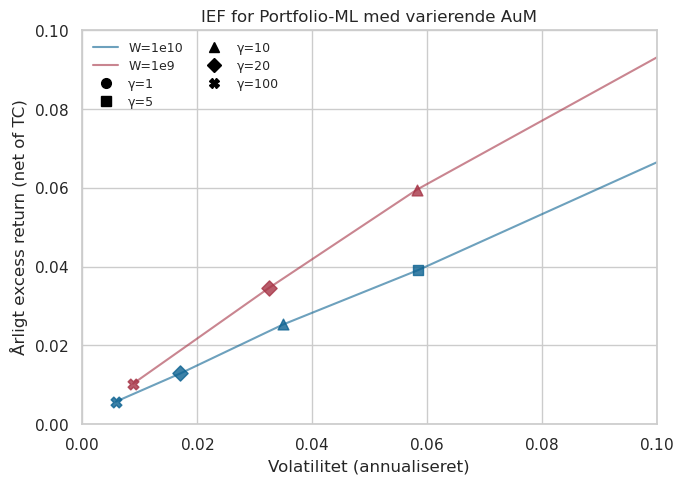

In [168]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Marker‑form for de forskellige γ’er
marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D",
    100: "X",
}

# Datasæt med linjer (W) og farver
data_specs = [
    (ef_ss_wealth_1e10, '1e10', '-', 'C0'),
    (ef_ss_wealth_1e9,  '1e9',  '-', 'C1'),
]

fig, ax = plt.subplots(figsize=(7, 5))

# 1) Tegn frontier‑linjerne med labels for W
for df, w_label, ls, color in data_specs:
    ef_port = df[df['type']=="Portfolio-ML"].sort_values("sd_annual")
    ax.plot(
        ef_port['sd_annual'],
        ef_port['r_tc'],
        linestyle=ls,
        color=color,
        alpha=0.6,
        label=f"W={w_label}"
    )

# 2) Tegn fyldte scatter‑markører for γ (uden labels)
for df, _, _, color in data_specs:
    ef_port = df[df['type']=="Portfolio-ML"]
    for gamma, marker in marker_map.items():
        sub = ef_port[ef_port['gamma_rel']==gamma]
        ax.scatter(
            sub['sd_annual'],
            sub['r_tc'],
            marker=marker,
            s=60,
            facecolors=color,
            edgecolors=color,
            alpha=0.8
        )

# 3) Lav proxy‑artists til γ‑markørerne (kun form, sort fyldte)
gamma_handles = [
    Line2D([0],[0],
           marker=marker_map[g],
           linestyle='None',
           markerfacecolor='black',
           markeredgecolor='black',
           markersize=7,
           label=f"γ={g}")
    for g in marker_map
]

# 4) Saml alle handles og labels
w_handles, w_labels = ax.get_legend_handles_labels()
handles = w_handles + gamma_handles
labels  = w_labels  + [h.get_label() for h in gamma_handles]

# 5) Én legend med 2 kolonner og overskrift over hver kolonne
leg = ax.legend(
    handles, labels,
    ncol=2,
    #title="W             γ",      # små mængder whitespace mellem W og γ
    title_fontsize=10,
    fontsize=9,
    frameon=False,
    borderpad=0.4,
    labelspacing=0.4,
    handletextpad=0.8,
    columnspacing=1.5,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

# 6) Resten
ax.set_xlim([0, 0.1]) #Manuelle græsner
ax.set_ylim([0, 0.1]) #Manuelle grænser
ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("IEF for Portfolio-ML med varierende AuM")
ax.grid(True)
plt.tight_layout()
plt.show()


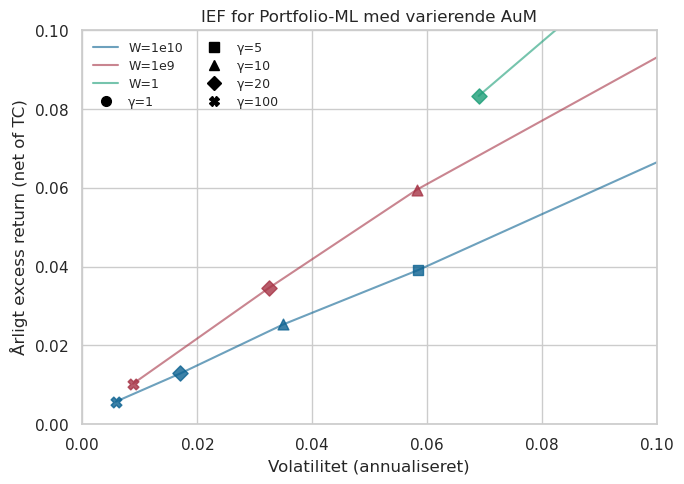

In [169]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Marker‑form for de forskellige γ’er
marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D",
    100: "X",
}

# Datasæt med linjer (W) og farver
data_specs = [
    (ef_ss_wealth_1e10, '1e10', '-', 'C0'), 
    (ef_ss_wealth_1e9,  '1e9',  '-', 'C1'),
    (ef_ss_wealth_1e1,  '1',  '-', 'C2'),
]

fig, ax = plt.subplots(figsize=(7, 5))

# 1) Tegn frontier‑linjerne med labels for W
for df, w_label, ls, color in data_specs:
    ef_port = df[df['type']=="Portfolio-ML"].sort_values("sd_annual")
    ax.plot(
        ef_port['sd_annual'],
        ef_port['r_tc'],
        linestyle=ls,
        color=color,
        alpha=0.6,
        label=f"W={w_label}"
    )

# 2) Tegn fyldte scatter‑markører for γ (uden labels)
for df, _, _, color in data_specs:
    ef_port = df[df['type']=="Portfolio-ML"]
    for gamma, marker in marker_map.items():
        sub = ef_port[ef_port['gamma_rel']==gamma]
        ax.scatter(
            sub['sd_annual'],
            sub['r_tc'],
            marker=marker,
            s=60,
            facecolors=color,
            edgecolors=color,
            alpha=0.8
        )

# 3) Lav proxy‑artists til γ‑markørerne (kun form, sort fyldte)
gamma_handles = [
    Line2D([0],[0],
           marker=marker_map[g],
           linestyle='None',
           markerfacecolor='black',
           markeredgecolor='black',
           markersize=7,
           label=f"γ={g}")
    for g in marker_map
]

# 4) Saml alle handles og labels
w_handles, w_labels = ax.get_legend_handles_labels()
handles = w_handles + gamma_handles
labels  = w_labels  + [h.get_label() for h in gamma_handles]

# 5) Én legend med 2 kolonner og overskrift over hver kolonne
leg = ax.legend(
    handles, labels,
    ncol=2,
    #title="W             γ",      # små mængder whitespace mellem W og γ
    title_fontsize=10,
    fontsize=9,
    frameon=False,
    borderpad=0.4,
    labelspacing=0.4,
    handletextpad=0.8,
    columnspacing=1.5,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

# 6) Resten
ax.set_xlim([0, 0.1]) #Manuelle græsner
ax.set_ylim([0, 0.1]) #Manuelle grænser
ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("IEF for Portfolio-ML med varierende AuM")
ax.grid(True)
plt.tight_layout()
plt.show()


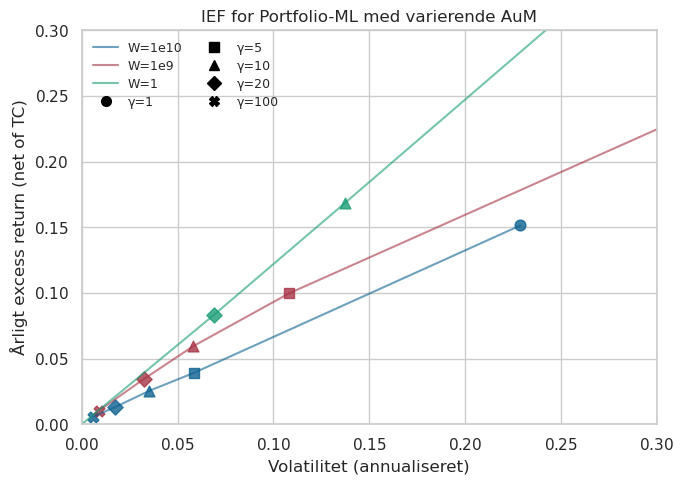

In [170]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd  # vigtigt for at kunne lave DataFrame med (0, 0)

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Marker‑form for de forskellige γ’er
marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D",
    100: "X",
}

# Datasæt med linjer (W) og farver
data_specs = [
    (ef_ss_wealth_1e10, '1e10', '-', 'C0'), 
    (ef_ss_wealth_1e9,  '1e9',  '-', 'C1'),
    (ef_ss_wealth_1e1,  '1',    '-', 'C2'),
]

fig, ax = plt.subplots(figsize=(7, 5))

# 1) Tegn frontier‑linjerne med labels for W
for df, w_label, ls, color in data_specs:
    ef_port = df[df['type'] == "Portfolio-ML"].sort_values("sd_annual")

    # Hvis W = 1, tilføj punkt (0, 0)
    if w_label == '1':
        zero_point = pd.DataFrame({'sd_annual': [0], 'r_tc': [0]})
        ef_port = pd.concat([zero_point, ef_port[['sd_annual', 'r_tc']]], ignore_index=True)

    ax.plot(
        ef_port['sd_annual'],
        ef_port['r_tc'],
        linestyle=ls,
        color=color,
        alpha=0.6,
        label=f"W={w_label}"
    )

# 2) Tegn fyldte scatter‑markører for γ (uden labels)
for df, _, _, color in data_specs:
    ef_port = df[df['type'] == "Portfolio-ML"]
    for gamma, marker in marker_map.items():
        sub = ef_port[ef_port['gamma_rel'] == gamma]
        ax.scatter(
            sub['sd_annual'],
            sub['r_tc'],
            marker=marker,
            s=60,
            facecolors=color,
            edgecolors=color,
            alpha=0.8
        )

# 3) Lav proxy‑artists til γ‑markørerne (kun form, sort fyldte)
gamma_handles = [
    Line2D([0], [0],
           marker=marker_map[g],
           linestyle='None',
           markerfacecolor='black',
           markeredgecolor='black',
           markersize=7,
           label=f"γ={g}")
    for g in marker_map
]

# 4) Saml alle handles og labels
w_handles, w_labels = ax.get_legend_handles_labels()
handles = w_handles + gamma_handles
labels = w_labels + [h.get_label() for h in gamma_handles]

# 5) Én legend med 2 kolonner og overskrift over hver kolonne
leg = ax.legend(
    handles, labels,
    ncol=2,
    #title="W         γ",  # aktiver hvis du vil
    title_fontsize=10,
    fontsize=9,
    frameon=False,
    borderpad=0.4,
    labelspacing=0.4,
    handletextpad=0.8,
    columnspacing=1.5,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

# 6) Resten
ax.set_xlim([0, 0.3])  # Manuelle grænser
ax.set_ylim([0, 0.3])
ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("IEF for Portfolio-ML med varierende AuM")
ax.grid(True)
plt.tight_layout()
plt.show()


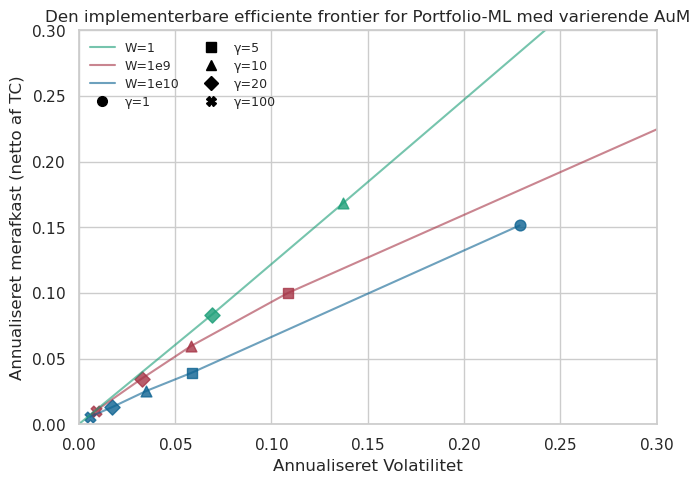

In [172]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd  # vigtigt for at kunne lave DataFrame med (0, 0)

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Marker‑form for de forskellige γ’er
marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D",
    100: "X",
}

# Datasæt med linjer (W) og farver
data_specs = [
    (ef_ss_wealth_1e10, '1e10', '-', 'C0'), 
    (ef_ss_wealth_1e9,  '1e9',  '-', 'C1'),
    (ef_ss_wealth_1e1,  '1',    '-', 'C2'),
]

fig, ax = plt.subplots(figsize=(7, 5))

# 1) Tegn frontier‑linjerne med labels for W
for df, w_label, ls, color in data_specs:
    ef_port = df[df['type'] == "Portfolio-ML"].sort_values("sd_annual")

    # Hvis W = 1, tilføj punkt (0, 0)
    if w_label == '1':
        zero_point = pd.DataFrame({'sd_annual': [0], 'r_tc': [0]})
        ef_port = pd.concat([zero_point, ef_port[['sd_annual', 'r_tc']]], ignore_index=True)

    ax.plot(
        ef_port['sd_annual'],
        ef_port['r_tc'],
        linestyle=ls,
        color=color,
        alpha=0.6,
        label=f"W={w_label}"
    )

# 2) Tegn fyldte scatter‑markører for γ (uden labels)
for df, _, _, color in data_specs:
    ef_port = df[df['type'] == "Portfolio-ML"]
    for gamma, marker in marker_map.items():
        sub = ef_port[ef_port['gamma_rel'] == gamma]
        ax.scatter(
            sub['sd_annual'],
            sub['r_tc'],
            marker=marker,
            s=60,
            facecolors=color,
            edgecolors=color,
            alpha=0.8
        )

# 3) Lav proxy‑artists til γ‑markørerne (kun form, sort fyldte)
gamma_handles = [
    Line2D([0], [0],
           marker=marker_map[g],
           linestyle='None',
           markerfacecolor='black',
           markeredgecolor='black',
           markersize=7,
           label=f"γ={g}")
    for g in marker_map
]

# 4) Hent W-handles og -labels, og omrokér rækkefølgen
w_handles, w_labels = ax.get_legend_handles_labels()
# Ønsket ordre: først index 2 ('1'), så 1 ('1e9'), så 0 ('1e10')
order = [2, 1, 0]
w_handles_reordered = [w_handles[i] for i in order]
w_labels_reordered  = [w_labels[i]  for i in order]

# Saml dem med γ‑handles
handles = w_handles_reordered + gamma_handles
labels  = w_labels_reordered  + [h.get_label() for h in gamma_handles]

# 5) Én legend med 2 kolonner
leg = ax.legend(
    handles, labels,
    ncol=2,
    #title="W         γ",  # aktiver hvis du vil have overskrift
    title_fontsize=10,
    fontsize=9,
    frameon=False,
    borderpad=0.4,
    labelspacing=0.4,
    handletextpad=0.8,
    columnspacing=1.5,
    loc="upper left"
)
leg.get_frame().set_linewidth(0.5)

# 6) Resten af styling
ax.set_xlim([0, 0.3])
ax.set_ylim([0, 0.3])
ax.set_xlabel("Annualiseret Volatilitet")
ax.set_ylabel("Annualiseret merafkast (netto af TC)")
ax.set_title("Den implementerbare efficiente frontier for Portfolio-ML med varierende AuM")
ax.grid(True)
plt.tight_layout()
fig.savefig(
    os.path.join(output_folder, "IEF_portfolio_ML_varierende_AuM.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


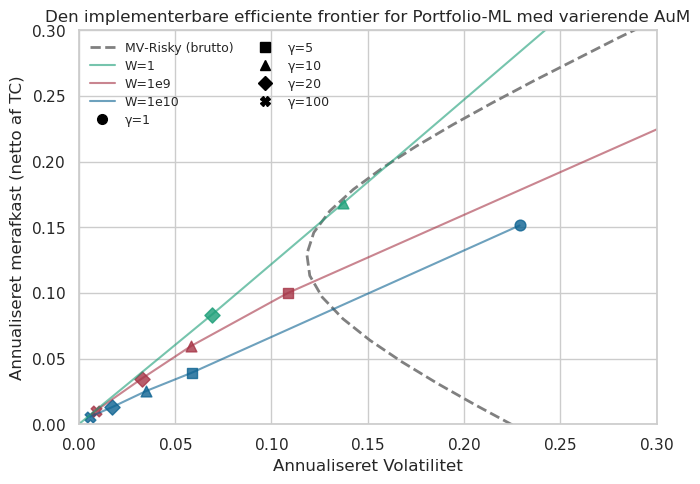

In [174]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd  # vigtigt for at kunne lave DataFrame med (0, 0)

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Marker‑form for de forskellige γ’er
marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D",
    100: "X",
}

# Datasæt med linjer (W) og farver
data_specs = [
    (ef_ss_wealth_1e10, '1e10', '-', 'C0'), 
    (ef_ss_wealth_1e9,  '1e9',  '-', 'C1'),
    (ef_ss_wealth_1e1,  '1',    '-', 'C2'),
]

fig, ax = plt.subplots(figsize=(7, 5))

# 0) Tegn mean-variance frontier (brutto) som blå, stiplet linje
line_mv, = ax.plot(
    mv_ss['sd'], 
    mv_ss['r_tc'],
    linestyle='--',
    color='grey',
    linewidth=2,
    label="MV‑Risky (brutto)"
)

# 1) Tegn de øvrige frontier‑linjer med labels for W
for df, w_label, ls, color in data_specs:
    ef_port = df[df['type'] == "Portfolio-ML"].sort_values("sd_annual")
    if w_label == '1':
        zero_point = pd.DataFrame({'sd_annual': [0], 'r_tc': [0]})
        ef_port = pd.concat([zero_point, ef_port[['sd_annual', 'r_tc']]], ignore_index=True)

    ax.plot(
        ef_port['sd_annual'],
        ef_port['r_tc'],
        linestyle=ls,
        color=color,
        alpha=0.6,
        label=f"W={w_label}"
    )

# 2) Tegn fyldte scatter‑markører for γ (uden labels)
for df, _, _, color in data_specs:
    ef_port = df[df['type'] == "Portfolio-ML"]
    for gamma, marker in marker_map.items():
        sub = ef_port[ef_port['gamma_rel'] == gamma]
        ax.scatter(
            sub['sd_annual'],
            sub['r_tc'],
            marker=marker,
            s=60,
            facecolors=color,
            edgecolors=color,
            alpha=0.8
        )

# 3) Lav proxy‑artists til γ‑markørerne (kun form, sort fyldte)
gamma_handles = [
    Line2D([0], [0],
           marker=marker_map[g],
           linestyle='None',
           markerfacecolor='black',
           markeredgecolor='black',
           markersize=7,
           label=f"γ={g}")
    for g in marker_map
]

# 4) Hent alle handles/labels, sæt i ønsket rækkefølge
all_handles, all_labels = ax.get_legend_handles_labels()

# Vi ved at 'MV‑Risky (brutto)' ligger først, derefter W=1, W=1e9, W=1e10
# Så reorder W-delen så W=1 først osv.
# find indexes for W-labels
w_indices = [all_labels.index(f"W={lbl}") for lbl in ['1','1e9','1e10']]
mv_index = all_labels.index("MV‑Risky (brutto)")

# Byg nye lister: først MV, så W i ønsket rækkefølge, så γ
handles = [all_handles[mv_index]] + [all_handles[i] for i in w_indices] + gamma_handles
labels  = [all_labels[mv_index]]  + [f"W={lbl}" for lbl in ['1','1e9','1e10']] + [h.get_label() for h in gamma_handles]

# 5) Én legend med 2 kolonner
leg = ax.legend(
    handles, labels,
    ncol=2,
    title_fontsize=10,
    fontsize=9,
    frameon=False,
    borderpad=0.4,
    labelspacing=0.4,
    handletextpad=0.8,
    columnspacing=1.5,
    loc="upper left"
)
leg.get_frame().set_linewidth(0.5)

# 6) Resten af styling
ax.set_xlim([0, 0.3])
ax.set_ylim([0, 0.3])
ax.set_xlabel("Annualiseret Volatilitet")
ax.set_ylabel("Annualiseret merafkast (netto af TC)")
ax.set_title("Den implementerbare efficiente frontier for Portfolio-ML med varierende AuM")
ax.grid(True)
plt.tight_layout()
fig.savefig(
    os.path.join(output_folder, "IEF_portfolio_ML_varierende_AuM_med_MV.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


# Static-ML* IEF - no demean - wealth 1e10

In [389]:
wealth_strs = ["1e10"]
gamma_vals  = [1, 5, 10, 20, 100]

files = [
    "static_no_demean_WEALTH1e10_GAMMA1.pkl",
    "static_no_demean_WEALTH1e10_GAMMA5.pkl",
    "static_no_demean_WEALTH1e10_GAMMA10.pkl",
    "static_no_demean_WEALTH1e10_GAMMA20.pkl",
    "static_no_demean_WEALTH1e10_GAMMA100.pkl",
]



# ========== Load & merge ==========
dfs = []
for fname in files:
    path = os.path.join(folder_name, fname)
    if not os.path.isfile(path):
        print(f"Advarsel: {fname} findes ikke.")
        continue

    # Load pickle
    with open(path, "rb") as f:
        obj = pickle.load(f)

    # Find selve DataFrame'en
    if isinstance(obj, pd.DataFrame):
        pf = obj
    elif hasattr(obj, "pf"):
        pf = obj.pf
    elif isinstance(obj, dict) and "pf" in obj:
        pf = obj["pf"]
    else:
        raise ValueError(f"Kunne ikke finde pf i {fname}")

    # Strip ".pkl" før regex
    base = os.path.splitext(fname)[0]

    # Stram regex: fang kun tal, evt. videnskabelig notation
    w_str = re.search(r"WEALTH([0-9eE.+-]+)(?=_GAMMA)", base).group(1)
    g_str = re.search(r"GAMMA([0-9eE.+-]+)$",           base).group(1)

    w = float(w_str)
    g = float(g_str)

    # Tilføj metadata
    pf = pf.assign(
        wealth_end = w,
        gamma_rel  = g,
        type       = "Static-ML*_no_demean"
    )

    dfs.append(pf)

# Sammensæt alt i ét DataFrame
ief_pfs = pd.concat(dfs, ignore_index=True)

In [390]:
# Tjek for dubletter (wealth_end, gamma_rel, type, eom_ret)
dups = (
    ief_pfs
    .groupby(["wealth_end","gamma_rel","type","eom_ret"])
    .size()
    .reset_index(name="count")
)
assert (dups["count"] == 1).all(), "Der er dubletter i dine data!"

# ========== Beregn summary-statistikker ==========
def summarize(group):
    gamma = group.name[2]
    print(gamma)
    r  = group["r"]
    tc = group["tc"]

    return pd.Series({
        "inv"       : group["inv"].mean(),
        "to"        : group["turnover"].mean(),
        "r_annual"  : r.mean() * 12,
        "sd_annual" : r.std()  * np.sqrt(12),
        "sr_gross"  : r.mean() / r.std() * np.sqrt(12),
        "tc_annual" : tc.mean() * 12,
        "r_tc"      : (r - tc).mean() * 12,
        "sr_net"    : (r - tc).mean() / r.std() * np.sqrt(12),
        "obj"       : (r.mean() - 0.5 * r.var() * gamma - tc.mean()) * 12
    })

ef_ss_static_no_demean_wealth_1e10 = (
    ief_pfs
    .groupby(["type","wealth_end","gamma_rel"])
    .apply(summarize)
    .reset_index()
)

print(ef_ss_static_no_demean_wealth_1e10)

1.0
5.0
10.0
20.0
100.0
                   type    wealth_end  gamma_rel        inv        to  \
0  Static-ML*_no_demean  1.000000e+10        1.0  13.108721  0.360030   
1  Static-ML*_no_demean  1.000000e+10        5.0   3.167727  0.130835   
2  Static-ML*_no_demean  1.000000e+10       10.0   1.596622  0.099627   
3  Static-ML*_no_demean  1.000000e+10       20.0   0.752316  0.069127   
4  Static-ML*_no_demean  1.000000e+10      100.0   0.207496  0.045488   

   r_annual  sd_annual  sr_gross  tc_annual      r_tc    sr_net       obj  
0  0.571312   0.820700  0.696128   0.012784  0.558528  0.680551  0.221754  
1  0.095962   0.114012  0.841679   0.001640  0.094321  0.827292  0.061824  
2  0.042996   0.051338  0.837509   0.001075  0.041921  0.816565  0.028743  
3  0.021103   0.024804  0.850814   0.000569  0.020534  0.827860  0.014382  
4  0.005146   0.005549  0.927251   0.000397  0.004749  0.855748  0.003209  


C:\Users\jonas\AppData\Local\Temp\ipykernel_20100\2919584186.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


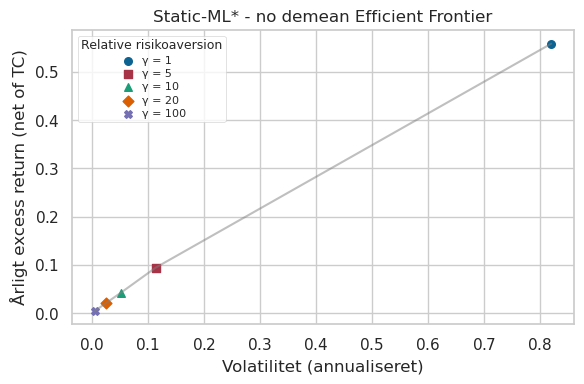

In [391]:
# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Antag: ef_ss indeholder kolonnerne 'type','sd_annual','r_tc','gamma_rel'
ef_port = ef_ss_static_no_demean_wealth_1e10.loc[ef_ss_static_no_demean_wealth_1e10['type'] == "Static-ML*_no_demean"]

marker_map = {
    1:   "o",
    #2:   "+",
    #3:   "x",
    5:   "s",
    10:  "^",
    20:  "D", 
    100: "X", 
}

fig, ax = plt.subplots(figsize=(6, 4))

for gamma, marker in marker_map.items():
    subset = ef_port[ef_port['gamma_rel'] == gamma]
    ax.scatter(
        subset['sd_annual'],
        subset['r_tc'],
        marker=marker,
        s=30,
        label = f"γ = {gamma}"  # eller f"$\\gamma$ = {gamma}"
    )

# Linje imellem punkterne
efs = ef_port.sort_values("sd_annual")
ax.plot(efs['sd_annual'], efs['r_tc'],
        linestyle='-', color='gray', alpha=0.5)

ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("Static-ML* - no demean Efficient Frontier")

# Gør legend-boxen mindre
leg = ax.legend(
    title="Relative risikoaversion",
    fontsize=8,
    title_fontsize=9,
    borderpad=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    markerscale=1,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

ax.grid(True)
plt.tight_layout()
plt.show()


# Static-ML* IEF - with demean - wealth 1e10

In [392]:
wealth_strs = ["1e10"]
gamma_vals  = [1, 5, 10, 20, 100]

files = [
    "static_WEALTH1e10_GAMMA1.pkl",
    "static_WEALTH1e10_GAMMA5.pkl",
    "static_WEALTH1e10_GAMMA10.pkl",
    "static_WEALTH1e10_GAMMA20.pkl",
    "static_WEALTH1e10_GAMMA100.pkl",
]



# ========== Load & merge ==========
dfs = []
for fname in files:
    path = os.path.join(folder_name, fname)
    if not os.path.isfile(path):
        print(f"Advarsel: {fname} findes ikke.")
        continue

    # Load pickle
    with open(path, "rb") as f:
        obj = pickle.load(f)

    # Find selve DataFrame'en
    if isinstance(obj, pd.DataFrame):
        pf = obj
    elif hasattr(obj, "pf"):
        pf = obj.pf
    elif isinstance(obj, dict) and "pf" in obj:
        pf = obj["pf"]
    else:
        raise ValueError(f"Kunne ikke finde pf i {fname}")

    # Strip ".pkl" før regex
    base = os.path.splitext(fname)[0]

    # Stram regex: fang kun tal, evt. videnskabelig notation
    w_str = re.search(r"WEALTH([0-9eE.+-]+)(?=_GAMMA)", base).group(1)
    g_str = re.search(r"GAMMA([0-9eE.+-]+)$",           base).group(1)

    w = float(w_str)
    g = float(g_str)

    # Tilføj metadata
    pf = pf.assign(
        wealth_end = w,
        gamma_rel  = g,
        type       = "Static-ML*_demean"
    )

    dfs.append(pf)

# Sammensæt alt i ét DataFrame
ief_pfs = pd.concat(dfs, ignore_index=True)

In [393]:
# Tjek for dubletter (wealth_end, gamma_rel, type, eom_ret)
dups = (
    ief_pfs
    .groupby(["wealth_end","gamma_rel","type","eom_ret"])
    .size()
    .reset_index(name="count")
)
assert (dups["count"] == 1).all(), "Der er dubletter i dine data!"

# ========== Beregn summary-statistikker ==========
def summarize(group):
    gamma = group.name[2]
    print(gamma)
    r  = group["r"]
    tc = group["tc"]

    return pd.Series({
        "inv"       : group["inv"].mean(),
        "to"        : group["turnover"].mean(),
        "r_annual"  : r.mean() * 12,
        "sd_annual" : r.std()  * np.sqrt(12),
        "sr_gross"  : r.mean() / r.std() * np.sqrt(12),
        "tc_annual" : tc.mean() * 12,
        "r_tc"      : (r - tc).mean() * 12,
        "sr_net"    : (r - tc).mean() / r.std() * np.sqrt(12),
        "obj"       : (r.mean() - 0.5 * r.var() * gamma - tc.mean()) * 12
    })

ef_ss_static_demean_wealth_1e10 = (
    ief_pfs
    .groupby(["type","wealth_end","gamma_rel"])
    .apply(summarize)
    .reset_index()
)

print(ef_ss_static_demean_wealth_1e10)

1.0
5.0
10.0
20.0
100.0
                type    wealth_end  gamma_rel        inv        to  r_annual  \
0  Static-ML*_demean  1.000000e+10        1.0  12.382774  2.375605  1.906403   
1  Static-ML*_demean  1.000000e+10        5.0   3.774150  1.048082  0.598276   
2  Static-ML*_demean  1.000000e+10       10.0   2.390794  0.782209  0.361853   
3  Static-ML*_demean  1.000000e+10       20.0   1.011927  0.531125  0.201588   
4  Static-ML*_demean  1.000000e+10      100.0   0.195050  0.125663  0.024426   

   sd_annual  sr_gross  tc_annual      r_tc    sr_net       obj  
0   0.911623  2.091218   0.530715  1.375688  1.509054  0.960160  
1   0.323288  1.850597   0.114916  0.483360  1.495136  0.222072  
2   0.211714  1.709160   0.066151  0.295701  1.396703  0.071588  
3   0.125656  1.604286   0.034498  0.167090  1.329741  0.009195  
4   0.017880  1.366139   0.002426  0.022000  1.230456  0.006016  


C:\Users\jonas\AppData\Local\Temp\ipykernel_20100\1015683989.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


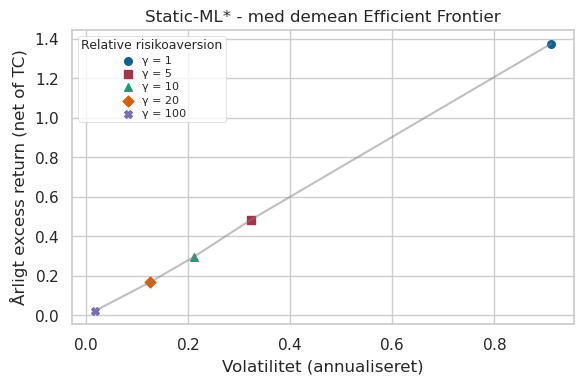

In [395]:
# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Antag: ef_ss indeholder kolonnerne 'type','sd_annual','r_tc','gamma_rel'
ef_port = ef_ss_static_demean_wealth_1e10.loc[ef_ss_static_demean_wealth_1e10['type'] == "Static-ML*_demean"]

marker_map = {
    1:   "o",
    #2:   "+",
    #3:   "x",
    5:   "s",
    10:  "^",
    20:  "D", 
    100: "X", 
}

fig, ax = plt.subplots(figsize=(6, 4))

for gamma, marker in marker_map.items():
    subset = ef_port[ef_port['gamma_rel'] == gamma]
    ax.scatter(
        subset['sd_annual'],
        subset['r_tc'],
        marker=marker,
        s=30,
        label = f"γ = {gamma}"  # eller f"$\\gamma$ = {gamma}"
    )

# Linje imellem punkterne
efs = ef_port.sort_values("sd_annual")
ax.plot(efs['sd_annual'], efs['r_tc'],
        linestyle='-', color='gray', alpha=0.5)

ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("Static-ML* - med demean Efficient Frontier")

# Gør legend-boxen mindre
leg = ax.legend(
    title="Relative risikoaversion",
    fontsize=8,
    title_fontsize=9,
    borderpad=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    markerscale=1,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

ax.grid(True)
plt.tight_layout()
plt.show()


# Static-ML* IEF med og uden demean wealth 1e10 

In [402]:
ef_ss_static_no_demean_wealth_1e10

,type,wealth_end,gamma_rel,inv,to,r_annual,sd_annual,sr_gross,tc_annual,r_tc,sr_net,obj
0,Static-ML*_no_demean,1.000000e+10,1.0,13.108721,0.360030,0.571312,0.820700,0.696128,0.012784,0.558528,0.680551,0.221754
1,Static-ML*_no_demean,1.000000e+10,5.0,3.167727,0.130835,0.095962,0.114012,0.841679,0.001640,0.094321,0.827292,0.061824
2,Static-ML*_no_demean,1.000000e+10,10.0,1.596622,0.099627,0.042996,0.051338,0.837509,0.001075,0.041921,0.816565,0.028743
3,Static-ML*_no_demean,1.000000e+10,20.0,0.752316,0.069127,0.021103,0.024804,0.850814,0.000569,0.020534,0.827860,0.014382
4,Static-ML*_no_demean,1.000000e+10,100.0,0.207496,0.045488,0.005146,0.005549,0.927251,0.000397,0.004749,0.855748,0.003209


In [403]:
ef_ss_static_demean_wealth_1e10

,type,wealth_end,gamma_rel,inv,to,r_annual,sd_annual,sr_gross,tc_annual,r_tc,sr_net,obj
0,Static-ML*_demean,1.000000e+10,1.0,12.382774,2.375605,1.906403,0.911623,2.091218,0.530715,1.375688,1.509054,0.960160
1,Static-ML*_demean,1.000000e+10,5.0,3.774150,1.048082,0.598276,0.323288,1.850597,0.114916,0.483360,1.495136,0.222072
2,Static-ML*_demean,1.000000e+10,10.0,2.390794,0.782209,0.361853,0.211714,1.709160,0.066151,0.295701,1.396703,0.071588
3,Static-ML*_demean,1.000000e+10,20.0,1.011927,0.531125,0.201588,0.125656,1.604286,0.034498,0.167090,1.329741,0.009195
4,Static-ML*_demean,1.000000e+10,100.0,0.195050,0.125663,0.024426,0.017880,1.366139,0.002426,0.022000,1.230456,0.006016


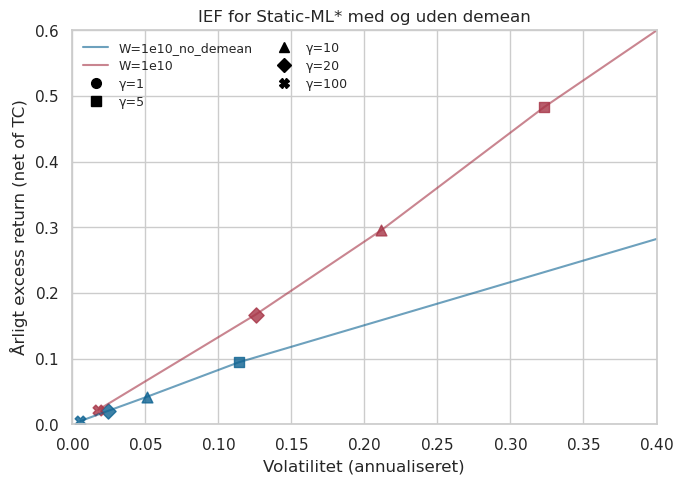

In [408]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Brug matplotlib's egen mathtext (ikke system‑LaTeX)
mpl.rcParams['text.usetex'] = False

# Marker-form for de forskellige γ’er
marker_map = {
    1:   "o",
    5:   "s",
    10:  "^",
    20:  "D",
    100: "X",
}

# Datasæt med linjer (W) og farver
data_specs = [
    (ef_ss_static_no_demean_wealth_1e10, '1e10_no_demean', 'Static-ML*_no_demean', 'C0'),
    (ef_ss_static_demean_wealth_1e10,    '1e10', 'Static-ML*_demean',    'C1'),
]

fig, ax = plt.subplots(figsize=(7, 5))

# 1) Tegn frontier-linjerne
for df, w_label, type_value, color in data_specs:
    ef_port = df[df['type'] == type_value].sort_values("sd_annual")
    if not ef_port.empty:
        ax.plot(
            ef_port['sd_annual'],
            ef_port['r_tc'],
            linestyle='-',
            color=color,
            alpha=0.6,
            label=f"W={w_label}"
        )

# 2) Tegn fyldte scatter-markører for γ (kun for _demean)
for df, _, type_value, color in data_specs:
    if "demean" in type_value:  # kun lav punkter for "demean"
        ef_port = df[df['type'] == type_value]
        for gamma, marker in marker_map.items():
            sub = ef_port[ef_port['gamma_rel'] == gamma]
            if not sub.empty:
                ax.scatter(
                    sub['sd_annual'],
                    sub['r_tc'],
                    marker=marker,
                    s=60,
                    facecolors=color,
                    edgecolors=color,
                    alpha=0.8
                )

# 3) Lav proxy-artists til γ-markørerne
gamma_handles = [
    Line2D([0], [0],
           marker=marker_map[g],
           linestyle='None',
           markerfacecolor='black',
           markeredgecolor='black',
           markersize=7,
           label=f"γ={g}")
    for g in marker_map
]

# 4) Saml alle handles og labels
w_handles, w_labels = ax.get_legend_handles_labels()
handles = w_handles + gamma_handles
labels = w_labels + [h.get_label() for h in gamma_handles]

# 5) Én legend med 2 kolonner
leg = ax.legend(
    handles, labels,
    ncol=2,
    # title="W         γ",  # kan aktiveres for kolonne-titel
    title_fontsize=10,
    fontsize=9,
    frameon=False,
    borderpad=0.4,
    labelspacing=0.4,
    handletextpad=0.8,
    columnspacing=1.5,
    loc="best"
)
leg.get_frame().set_linewidth(0.5)

# 6) Resten
ax.set_xlim([0, 0.4])
ax.set_ylim([0, 0.6])
ax.set_xlabel("Volatilitet (annualiseret)")
ax.set_ylabel("Årligt excess return (net of TC)")
ax.set_title("IEF for Static-ML* med og uden demean")
ax.grid(True)
plt.tight_layout()
plt.show()


# Performance for alle - uden demean - wealth lig 1e9 og gamma lig 10

In [82]:
wealth

,eom,wealth,mu_ld1
0,1952-11-30,1.478890e+05,0.030713
1,1952-12-31,1.525750e+05,-0.001577
2,1953-01-31,1.523347e+05,-0.001627
3,1953-02-28,1.520872e+05,-0.012860
4,1953-03-31,1.501562e+05,-0.027552
...,...,...,...
837,2022-08-31,1.007982e+09,-0.091370
838,2022-09-30,9.235940e+08,0.081350
839,2022-10-31,1.005382e+09,0.051329
840,2022-11-30,1.059779e+09,-0.059779


In [83]:
ew = portfolio_choice_functions.ew_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set=pf_set)
mkt = portfolio_choice_functions.mkt_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set= pf_set)
rw = portfolio_choice_functions.rw_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set= pf_set)
mv = portfolio_choice_functions.mv_implement(data=chars, cov_list=barra_cov ,wealth=wealth, dates=dates_oos, pf_set= pf_set)
factor_ml = portfolio_choice_functions.factor_ml_implement(data = chars, wealth = wealth, dates= dates_oos, n_pfs=settings["factor_ml"]["n_pfs"]
, gam=pf_set['gamma_rel'])
tpf = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

In [85]:
#pfml_gam10_path = "./much_more_data/pfml_seed_10_NEW_WEALTH1e10_GAMMA10.pkl"
#pfml_gam10_path = "./much_more_data/pfml_seed_10_gam_10_new_no_standarlization.pkl" #Uden standardisering med wealth 1e9 
#Base case: pfml_seed_10_NEW_WEALTH1e9_GAMMA10.pkl
#pfml_gam10_path = "./much_more_data/pfml_seed_10_gam_10_new_low_wealth.pkl" #med standardisering med wealth 1e9
pfml_gam10_path = "./much_more_data/pfml_seed_10_NEW_WEALTH1e9_GAMMA10.pkl"
static_gam10_no_demean_path = "./much_more_data/static_no_demean_WEALTH1e9_GAMMA10.pkl"
#static_gam10_with_demean_path = "./much_more_data/static_WEALTH1e10_GAMMA10.pkl"

In [86]:
import pickle
with open(pfml_gam10_path, "rb") as f:
    pfml = pickle.load(f)

with open(pfml_gam10_path, "rb") as f1, open(static_gam10_no_demean_path, "rb") as f2: #, open(static_gam10_with_demean_path, "rb") as f3:
    pfml     = pickle.load(f1)
    static_no_demean    = pickle.load(f2)
    #static_with_demean = pickle.load(f3)


In [87]:
bm_pfs = pd.concat(
    [tpf["pf"], factor_ml["pf"], ew["pf"], mkt["pf"], rw["pf"], mv["pf"], static_no_demean["pf"], pfml["pf"]], 
    ignore_index=True
)
# Konverter eom_ret til dato
bm_pfs['eom_ret'] = pd.to_datetime(bm_pfs['eom_ret'])

# Erstat "Rank-Weighted" med "Rank-ML" i kolonnen type
bm_pfs.loc[bm_pfs['type'] == 'Rank-Weighted', 'type'] = 'Rank-ML'

pfs = bm_pfs
static_ml_star = pfs[pfs['type'] == "Static-ML*"]

subset_hps = static_no_demean["hps"][
    static_no_demean["hps"]["eom_ret"].isin(static_no_demean["pf"]["eom_ret"]) &
    (static_no_demean["hps"]["k"] == 1) &
    (static_no_demean["hps"]["g"] == 0) &
    (static_no_demean["hps"]["u"] == 1)
].copy()

subset_hps["eom_ret"] = pd.to_datetime(subset_hps["eom_ret"])
subset_hps = subset_hps[["eom_ret", "inv", "shorting", "turnover", "r", "tc"]]
subset_hps["type"] = "Static-ML"

pfs = pd.concat([   # Static-ML portefølje-tidsserie
    bm_pfs,         # Benchmark-porteføljer
    subset_hps      # Filtreret subset af static["hps"]
], ignore_index=True)

pf_order = [
    "Portfolio-ML",  # denne er kommenteret ud som i R-koden
    "Static-ML",
    "Static-ML*",
    "Markowitz-ML",
    "Factor-ML",
    "Rank-ML",
    "Minimum Variance",
    "1/N",
    "Market"
]

In [88]:
main_types = pf_order

# 3) Tildel factor-rækkefølgen og sorter
pfs['type'] = pd.Categorical(pfs['type'], categories=pf_order, ordered=True)
pfs = pfs.sort_values(by=['type', 'eom_ret'])

pfs['e_var_adj'] = pfs.groupby('type')['r'].transform(lambda x: (x - x.mean())**2)

# Beregn utility_t: r - tc - 0.5 * e_var_adj * gamma_rel (her antages pf_set være en dictionary)
pfs['utility_t'] = pfs['r'] - pfs['tc'] - 0.5 * pfs['e_var_adj'] * pf_set['gamma_rel']

# Portfolio summary stats --------------
def summary_stats(group):
    n = group.shape[0]
    inv = group['inv'].mean()
    shorting = group['shorting'].mean()
    turnover_notional = group['turnover'].mean()
    r_mean = group['r'].mean() * 12
    sd = group['r'].std() * np.sqrt(12)
    sr_gross = (group['r'].mean()/group['r'].std() * np.sqrt(12)) if group['r'].std() != 0 else np.nan
    tc = group['tc'].mean() * 12
    r_tc = (group['r'] - group['tc']).mean() * 12
    sr = ((group['r'] - group['tc']).mean()/group['r'].std() * np.sqrt(12)) if group['r'].std() != 0 else np.nan
    obj = (group['r'].mean() - 0.5 * group['r'].var() * pf_set['gamma_rel'] - group['tc'].mean()) * 12
    return pd.Series({
        'n': n,
        'inv': inv,
        'shorting': shorting,
        'turnover_notional': turnover_notional,
        'r': r_mean,
        'sd': sd,
        'sr_gross': sr_gross,
        'tc': tc,
        'r_tc': r_tc,
        'sr': sr,
        'obj': obj
    })

pf_summary = pfs.groupby('type').apply(summary_stats).reset_index()
pf_summary = pf_summary.sort_values(by='type')

# Fjern ikke-essentielle typer (hvis nødvendigt)
pfs = pfs[pfs['type'].isin(main_types)].copy()
pfs['type'] = pd.Categorical(pfs['type'], categories=main_types, ordered=True)

# Udskriv resuméet
print(pf_summary)

               type      n        inv   shorting  turnover_notional         r  \
0      Portfolio-ML  144.0   1.270098   0.416651           0.242741  0.060580   
1         Static-ML  144.0  13.880603   6.456266           1.355917  0.243769   
2        Static-ML*  144.0   1.975410   0.811853           0.386400  0.054211   
3      Markowitz-ML  144.0  32.825146  15.844005          29.008202  0.447758   
4         Factor-ML  144.0   2.000000   1.000000           2.047282  0.018321   
5           Rank-ML  144.0   2.000000   1.000000           1.168758  0.025328   
6  Minimum Variance  144.0   3.115588   1.057794           1.750613  0.127614   
7               1/N  144.0   1.000000   0.000000           0.061911  0.127185   
8            Market  144.0   1.000000   0.000000           0.007638  0.117418   

         sd  sr_gross         tc       r_tc          sr        obj  
0  0.058284  1.039390   0.001038   0.059542    1.021582   0.042557  
1  0.211555  1.152275   0.018514   0.225255    1.06

C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\1972976176.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\1972976176.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\1972976176.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence thi

In [89]:

gamma_rel = pf_set["gamma_rel"]  

# Beregn portefølje-sammenfatningsstatistikker
pf_summary = pfs.groupby("type").agg(
    n=("eom_ret", "count"),  # Antal observationer
    inv=("inv", "mean"),  # Gennemsnitlig investering
    shorting=("shorting", "mean"),  # Gennemsnitlig shorting
    turnover_notional=("turnover", "mean"),  # Gennemsnitlig omsætning (turnover)
    r=("r", lambda x: x.mean() * 12),  # Gennemsnitligt afkast annualiseret
    sd=("r", lambda x: x.std() * (12**0.5)),  # Volatilitet annualiseret
    sr_gross=("r", lambda x: x.mean() / x.std() * (12**0.5) if x.std() > 0 else None),  # Sharpe Ratio før transaktionsomkostninger
    tc=("tc", lambda x: x.mean() * 12),  # Gennemsnitlige transaktionsomkostninger annualiseret
    r_tc=("r", lambda x: (x - pfs.loc[x.index, "tc"]).mean() * 12),  # Nettoafkast efter transaktionsomkostninger
    sr=("r", lambda x: (x - pfs.loc[x.index, "tc"]).mean() / x.std() * (12**0.5) if x.std() > 0 else None),  # Sharpe Ratio efter transaktionsomkostninger
    obj=("r", lambda x: (x.mean() - 0.5 * x.var() * gamma_rel - pfs.loc[x.index, "tc"].mean()) * 12)  # Optimeringsmål
).reset_index()

# Sorter efter type
pf_summary = pf_summary.sort_values(by="type")

# Filtrer pfs til kun at inkludere de relevante typer (main_types skal defineres)
main_types = ["Markowitz-ML", "Factor-ML", "Market", "Rank-ML", "Minimum Variance", "Static-ML", "Static-ML*", "Portfolio-ML"]  # Tilpas efter behov
pfs = pfs[pfs["type"].isin(main_types)]
pfs["type"] = pd.Categorical(pfs["type"], categories=main_types, ordered=True)

# Vis resultatet
from IPython.display import display
display(pf_summary)

C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\2649120793.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,type,n,inv,shorting,turnover_notional,r,sd,sr_gross,tc,r_tc,sr,obj
0,Portfolio-ML,144,1.270098,0.416651,0.242741,0.060580,0.058284,1.039390,0.001038,0.059542,1.021582,0.042557
1,Static-ML,144,13.880603,6.456266,1.355917,0.243769,0.211555,1.152275,0.018514,0.225255,1.064759,0.001478
2,Static-ML*,144,1.975410,0.811853,0.386400,0.054211,0.054219,0.999859,0.001685,0.052526,0.968785,0.037828
3,Markowitz-ML,144,32.825146,15.844005,29.008202,0.447758,0.455910,0.982119,71.293004,-70.845246,-155.392964,-71.884517
4,Factor-ML,144,2.000000,1.000000,2.047282,0.018321,0.134316,0.136406,0.227445,-0.209123,-1.556952,-0.299327
5,Rank-ML,144,2.000000,1.000000,1.168758,0.025328,0.091638,0.276395,0.108550,-0.083222,-0.908156,-0.125209
6,Minimum Variance,144,3.115588,1.057794,1.750613,0.127614,0.118592,1.076076,0.247223,-0.119609,-1.008575,-0.189929
7,1/N,144,1.000000,0.000000,0.061911,0.127185,0.170182,0.747344,0.000692,0.126493,0.743278,-0.018317
8,Market,144,1.000000,0.000000,0.007638,0.117418,0.143384,0.818905,0.000003,0.117415,0.818885,0.014620


In [91]:
import pandas as pd
from IPython.display import display

# --- 1) Antag pf_summary er dit allerede beregnede DataFrame ---

# Navnekort fra pf_summary til den endelige tabel
cols_map = {
    "type":              "Metode",
    "r":                 "R",
    "sd":                "Vol.",
    "sr_gross":          r"SR$_{\mathrm{brutto}}$",
    "tc":                "TC",
    "r_tc":              "R-TC",
    "sr":                r"SR$_{\mathrm{net}}$",
    "obj":               "Nytte",
    "turnover_notional": "Turnover",
    "inv":               "Lev."
}

# Omnavngiv og arranger i præcis denne rækkefølge
ordered_cols = [
    "Metode", "R", "Vol.", r"SR$_{\mathrm{brutto}}$", 
    "TC", "R-TC", r"SR$_{\mathrm{net}}$",
    "Nytte", "Turnover", "Lev."
]

pf_table = (
    pf_summary
      .rename(columns=cols_map)
      [ordered_cols]
)

# --- 2) Definér formatering per kolonne ---
formatters = {
    "R":        "{:.2f}".format,
    "Vol.":     "{:.2f}".format,
    r"SR$_{\mathrm{brutto}}$": "{:.2f}".format,
    "TC":       "{:.3f}".format,
    "R-TC":     "{:.2f}".format,
    r"SR$_{\mathrm{net}}$":  "{:.2f}".format,
    "Nytte":  "{:.3f}".format,
    "Turnover": "{:.2f}".format,
    "Lev.":     "{:.2f}".format,
}

# --- 3) Vis i Jupyter uden indeks (brug hide(axis="index")) ---
styled = (
    pf_table
      .style
      .format(formatters)
      .hide(axis="index")
)
display(styled)

# --- 4) (Valgfrit) Eksportér til LaTeX-kompatibel tabel ---
latex = pf_table.to_latex(
    index=False,
    formatters=formatters,
    escape=False,           # tillad LaTeX i kolonne-navne
    column_format="l" + "r"*9
)
print(latex)


Metode,R,Vol.,SR$_{\mathrm{brutto}}$,TC,R-TC,SR$_{\mathrm{net}}$,Nytte,Turnover,Lev.
Portfolio-ML,0.06,0.06,1.04,0.001,0.06,1.02,0.043,0.24,1.27
Static-ML,0.24,0.21,1.15,0.019,0.23,1.06,0.001,1.36,13.88
Static-ML*,0.05,0.05,1.00,0.002,0.05,0.97,0.038,0.39,1.98
Markowitz-ML,0.45,0.46,0.98,71.293,-70.85,-155.39,-71.885,29.01,32.83
Factor-ML,0.02,0.13,0.14,0.227,-0.21,-1.56,-0.299,2.05,2.00
Rank-ML,0.03,0.09,0.28,0.109,-0.08,-0.91,-0.125,1.17,2.00
Minimum Variance,0.13,0.12,1.08,0.247,-0.12,-1.01,-0.190,1.75,3.12
1/N,0.13,0.17,0.75,0.001,0.13,0.74,-0.018,0.06,1.00
Market,0.12,0.14,0.82,0.000,0.12,0.82,0.015,0.01,1.00


\begin{tabular}{lrrrrrrrrr}
\toprule
Metode & R & Vol. & SR$_{\mathrm{brutto}}$ & TC & R-TC & SR$_{\mathrm{net}}$ & Nytte & Turnover & Lev. \\
\midrule
Portfolio-ML & 0.06 & 0.06 & 1.04 & 0.001 & 0.06 & 1.02 & 0.043 & 0.24 & 1.27 \\
Static-ML & 0.24 & 0.21 & 1.15 & 0.019 & 0.23 & 1.06 & 0.001 & 1.36 & 13.88 \\
Static-ML* & 0.05 & 0.05 & 1.00 & 0.002 & 0.05 & 0.97 & 0.038 & 0.39 & 1.98 \\
Markowitz-ML & 0.45 & 0.46 & 0.98 & 71.293 & -70.85 & -155.39 & -71.885 & 29.01 & 32.83 \\
Factor-ML & 0.02 & 0.13 & 0.14 & 0.227 & -0.21 & -1.56 & -0.299 & 2.05 & 2.00 \\
Rank-ML & 0.03 & 0.09 & 0.28 & 0.109 & -0.08 & -0.91 & -0.125 & 1.17 & 2.00 \\
Minimum Variance & 0.13 & 0.12 & 1.08 & 0.247 & -0.12 & -1.01 & -0.190 & 1.75 & 3.12 \\
1/N & 0.13 & 0.17 & 0.75 & 0.001 & 0.13 & 0.74 & -0.018 & 0.06 & 1.00 \\
Market & 0.12 & 0.14 & 0.82 & 0.000 & 0.12 & 0.82 & 0.015 & 0.01 & 1.00 \\
\bottomrule
\end{tabular}



In [92]:
pfml["pf"] #Portfolio-ML
tpf["pf"] #Markowitz-ML
subset_hps #Static-ML
static_no_demean["pf"] #Static-ML*
factor_ml["pf"] #Faktor-ML
#[tpf["pf"], factor_ml["pf"], ew["pf"], mkt["pf"], rw["pf"], mv["pf"], static_no_demean["pf"], pfml["pf"]], 
#    ignore_index=True
#)

,inv,shorting,turnover,r,tc,eom_ret,type
0,2.0,1.0,2.921968,-0.005549,0.011200,2011-01-31,Factor-ML
1,2.0,1.0,2.555370,-0.002625,0.012968,2011-02-28,Factor-ML
2,2.0,1.0,2.519542,-0.013534,0.011434,2011-03-31,Factor-ML
3,2.0,1.0,2.489009,0.005356,0.008649,2011-04-30,Factor-ML
4,2.0,1.0,3.020618,-0.013795,0.018815,2011-05-31,Factor-ML
...,...,...,...,...,...,...,...
139,2.0,1.0,1.748901,-0.021038,0.029517,2022-08-31,Factor-ML
140,2.0,1.0,1.401604,-0.062454,0.022617,2022-09-30,Factor-ML
141,2.0,1.0,1.789937,0.056395,0.022639,2022-10-31,Factor-ML
142,2.0,1.0,2.187531,0.052917,0.032109,2022-11-30,Factor-ML


In [93]:
pfml["pf"]

,inv,shorting,turnover,r,tc,eom_ret,type
0,0.548956,0.120306,0.901078,0.000330,0.000302,2011-01-31,Portfolio-ML
1,0.694525,0.189635,0.262274,0.016278,0.000065,2011-02-28,Portfolio-ML
2,0.727955,0.210241,0.202522,0.012221,0.000039,2011-03-31,Portfolio-ML
3,0.757904,0.224130,0.152062,0.015182,0.000024,2011-04-30,Portfolio-ML
4,0.767927,0.231778,0.182532,0.004773,0.000032,2011-05-31,Portfolio-ML
...,...,...,...,...,...,...,...
139,1.208975,0.419400,0.245152,-0.012299,0.000082,2022-08-31,Portfolio-ML
140,1.209628,0.407643,0.211499,-0.020785,0.000075,2022-09-30,Portfolio-ML
141,1.204960,0.410004,0.184399,0.045099,0.000058,2022-10-31,Portfolio-ML
142,1.205735,0.417524,0.182330,0.027874,0.000065,2022-11-30,Portfolio-ML


In [94]:
output_folder = r"C:\Users\jonas\OneDrive\CBS\Kandidat - CBS\Speciale\Resultater Python"

C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\2323537415.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\2323537415.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\jonas\AppData\Local\Temp\ipykernel_3448\2323537415.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence th

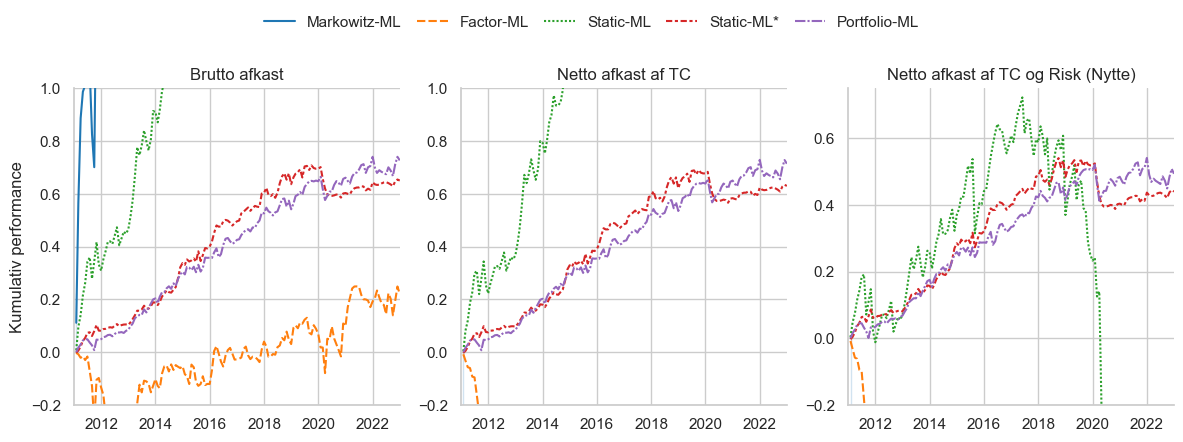

            main               alt  prob_main_outperf
0   Markowitz-ML         Factor-ML       0.000000e+00
1   Markowitz-ML            Market       0.000000e+00
2   Markowitz-ML           Rank-ML       0.000000e+00
3   Markowitz-ML  Minimum Variance       0.000000e+00
4   Markowitz-ML         Static-ML       0.000000e+00
5   Markowitz-ML        Static-ML*       0.000000e+00
6   Markowitz-ML      Portfolio-ML       0.000000e+00
7      Factor-ML      Markowitz-ML       1.000000e+00
8      Factor-ML            Market       2.288503e-12
9      Factor-ML           Rank-ML       1.217719e-09
10     Factor-ML  Minimum Variance       1.165870e-02
11     Factor-ML         Static-ML       4.666687e-05
12     Factor-ML        Static-ML*       0.000000e+00
13     Factor-ML      Portfolio-ML       0.000000e+00
14     Static-ML      Markowitz-ML       1.000000e+00
15     Static-ML         Factor-ML       9.999533e-01
16     Static-ML            Market       3.114373e-01
17     Static-ML           R

In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# --- 0) Indstil dine main_types og gamma_rel ---
main_types = [
    "Markowitz-ML","Factor-ML","Static-ML","Static-ML*","Portfolio-ML"
]
gamma_rel  = pf_set["gamma_rel"]

# --- 1) Beregn cumulativ performance additivt ---
pfs2 = pfs.copy()
pfs2["eom_ret"]   = pd.to_datetime(pfs2["eom_ret"])
pfs2["utility_t"] = pfs2["r"] - 0.5 * gamma_rel * pfs2["r"]**2 - pfs2["tc"]

pfs2 = pfs2.sort_values("eom_ret")
pfs2["cumret"]         = pfs2.groupby("type")["r"].cumsum()
pfs2["cumret_tc"]      = (
    pfs2.groupby("type")
        .apply(lambda x: (x["r"] - x["tc"]).cumsum())
        .reset_index(level=0, drop=True)
)
pfs2["cumret_tc_risk"] = pfs2.groupby("type")["utility_t"].cumsum()

# --- 2) Filtrér til kun main_types og “gør lang” ---
ts_data = (
    pfs2[pfs2["type"].isin(main_types)]
      .loc[:, ["type","eom_ret","cumret","cumret_tc","cumret_tc_risk"]]
      .melt(
         id_vars   = ["type","eom_ret"],
         value_vars= ["cumret","cumret_tc","cumret_tc_risk"],
         var_name  = "metric",
         value_name= "value"
      )
)

# --- 3) Tilføj nul‑start for hver metode × metric på første måned ---
start = ts_data["eom_ret"].min()
zerorows = pd.DataFrame({
    "type":    np.repeat(main_types, 3),
    "eom_ret": pd.to_datetime(start),
    "metric":  ["cumret","cumret_tc","cumret_tc_risk"] * len(main_types),
    "value":   0.0
})
ts_data = pd.concat([zerorows, ts_data], ignore_index=True)

# --- 4) Pænere navne og ordering for facet-wrap ---
name_map = {
    "cumret":         "Brutto afkast",
    "cumret_tc":      "Netto afkast af TC",
    "cumret_tc_risk": "Netto afkast af TC og Risk (Nytte)"
}
ts_data["metric_pretty"] = ts_data["metric"].map(name_map)
ts_data["metric_pretty"] = pd.Categorical(
    ts_data["metric_pretty"],
    categories=[
      "Brutto afkast",
      "Netto afkast af TC",
      "Netto afkast af TC og Risk (Nytte)"
    ],
    ordered=True
)

# --- 5) Plot med Seaborn FacetGrid og manuelle y‑grænser + samlet legend uden titel ---
sns.set_style("whitegrid")
g = sns.FacetGrid(
    ts_data,
    col       = "metric_pretty",
    col_wrap  = 3,
    sharey    = False,
    height    = 4,
    aspect    = 1
)
g.map_dataframe(
    sns.lineplot,
    x       = "eom_ret",
    y       = "value",
    hue     = "type",
    style   = "type",
    palette = "tab10"
)

# Akse‑labels og titler
g.set_axis_labels("", "Kumulativ performance")
g.set_titles("{col_name}")
g.set(xlim=(pd.to_datetime("2010-12-31"), pd.to_datetime("2022-12-31")))

# Manuelle y‑aksens grænser
y_limits = {
    "Brutto afkast":               (-0.2, 1),
    "Netto afkast af TC":          (-0.2, 1),
    "Netto afkast af TC og Risk (Nytte)":  (-0.2, 0.75),
}
for ax, metric in zip(g.axes.flat, g.col_names):
    ax.set_ylim(*y_limits[metric])

# Hent handles/labels fra første subplot
handles, labels = g.axes[0].get_legend_handles_labels()

# Én fælles legend øverst – uden titel
g.fig.legend(
    handles, labels,
    ncol          = len(labels),
    loc           = "upper center",
    bbox_to_anchor= (0.5, 1.12),
    frameon       = False,
    columnspacing = 1.0,
    title         = None   # fjerner titel
)

# Udvid top‑margin så legend ikke overlapper
g.fig.subplots_adjust(top=0.85)

plt.tight_layout()
plt.savefig(
    os.path.join(output_folder, "performance_grafer.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()

# --- 6) Beregn probability of outperformance som før ---
wide = pfs2.pivot(
    index   = "eom_ret",
    columns = "type",
    values  = "utility_t"
).dropna()

outperf = []
n_obs   = len(wide)
for main in main_types:
    for alt in wide.columns:
        if alt == main:
            continue
        diff  = wide[main] - wide[alt]
        mu    = diff.mean()
        sigma = diff.std(ddof=1) / np.sqrt(n_obs)
        prob  = 1 - norm.cdf(0, loc=mu, scale=sigma)
        outperf.append({
            "main": main,
            "alt":  alt,
            "prob_main_outperf": prob
        })

prob_df = pd.DataFrame(outperf)
print(prob_df)


In [102]:
import pandas as pd
import numpy as np

# Antag prob_df har kolonnerne ['main','alt','prob_main_outperf']
main_types = [
    "Portfolio-ML", "Static-ML","Static-ML*",
    "Factor-ML","Markowitz-ML"
]

# 1) Vend “long” prob_df om til et matrix‐format
mat = (
    prob_df
    .pivot(index="main", columns="alt", values="prob_main_outperf")
    # Sørg for rækkefølge på både rækker og kolonner
    .reindex(index=main_types, columns=main_types)
)

# 2) Konverter til procenter og formatter med 1 decimal
mat_pct = (mat * 100).round(1).astype(str) + r"\%"

# 3) Sæt diagonal‐elementerne til tom streng
mask = np.eye(len(mat_pct), dtype=bool)
mat_pct = mat_pct.mask(mask, "")

# 4) Eksporter til LaTeX
latex = mat_pct.to_latex(
    index        = True,
    header       = True,
    escape       = False,               # bevar \% i output
    column_format= "l" + "r"*len(main_types),
    caption      = "Relative Probability of Outperformance",
    label        = "tab:prob_outperf"
)
print(latex)


\begin{table}
\caption{Relative Probability of Outperformance}
\label{tab:prob_outperf}
\begin{tabular}{lrrrrr}
\toprule
alt & Portfolio-ML & Static-ML & Static-ML* & Factor-ML & Markowitz-ML \\
main &  &  &  &  &  \\
\midrule
Portfolio-ML &  & 86.7\% & 64.5\% & 100.0\% & 100.0\% \\
Static-ML & 13.3\% &  & 12.5\% & 100.0\% & 100.0\% \\
Static-ML* & 35.5\% & 87.5\% &  & 100.0\% & 100.0\% \\
Factor-ML & 0.0\% & 0.0\% & 0.0\% &  & 100.0\% \\
Markowitz-ML & 0.0\% & 0.0\% & 0.0\% & 0.0\% &  \\
\bottomrule
\end{tabular}
\end{table}



In [103]:
pfml["pf"] #Portfolio-ML
tpf["pf"] #Markowitz-ML
subset_hps #Static-ML
static_no_demean["pf"] #Static-ML*
factor_ml["pf"] #Faktor-ML
#[tpf["pf"], factor_ml["pf"], ew["pf"], mkt["pf"], rw["pf"], mv["pf"], static_no_demean["pf"], pfml["pf"]], 
#    ignore_index=True
#)

,inv,shorting,turnover,r,tc,eom_ret,type
0,2.0,1.0,2.921968,-0.005549,0.011200,2011-01-31,Factor-ML
1,2.0,1.0,2.555370,-0.002625,0.012968,2011-02-28,Factor-ML
2,2.0,1.0,2.519542,-0.013534,0.011434,2011-03-31,Factor-ML
3,2.0,1.0,2.489009,0.005356,0.008649,2011-04-30,Factor-ML
4,2.0,1.0,3.020618,-0.013795,0.018815,2011-05-31,Factor-ML
...,...,...,...,...,...,...,...
139,2.0,1.0,1.748901,-0.021038,0.029517,2022-08-31,Factor-ML
140,2.0,1.0,1.401604,-0.062454,0.022617,2022-09-30,Factor-ML
141,2.0,1.0,1.789937,0.056395,0.022639,2022-10-31,Factor-ML
142,2.0,1.0,2.187531,0.052917,0.032109,2022-11-30,Factor-ML


In [104]:
pfml["w"] #Portfolio-ML

,id,eom,w_start,w,tr_ld1,mu_ld1,match_count,w_start_diff
0,10032,2010-12-31,0.000115,0.000288,-0.126016,0.020052,0,0.0
1,10032,2011-01-31,0.000247,0.000328,0.162330,0.038821,0,0.0
2,10032,2011-02-28,0.000367,0.000246,0.115528,0.003383,0,0.0
3,10032,2011-03-31,0.000273,0.000304,0.040834,0.027662,0,0.0
4,10032,2011-04-30,0.000308,0.000229,0.021637,-0.015071,0,0.0
...,...,...,...,...,...,...,...,...
102047,92655,2022-07-31,0.003003,0.004395,-0.043528,-0.036188,0,0.0
102048,92655,2022-08-31,0.004361,0.006534,-0.024368,-0.091370,0,0.0
102049,92655,2022-09-30,0.007016,0.005237,0.098793,0.081350,0,0.0
102050,92655,2022-10-31,0.005322,0.006234,-0.013868,0.051329,0,0.0


In [105]:
import matplotlib as mpl

# Brug kun de fonte, du rent faktisk har, og sæt standard til sans‑serif:
mpl.rcParams['font.family']        = 'sans-serif'
mpl.rcParams['font.sans-serif']    = ['DejaVu Sans', 'Arial', 'Liberation Sans']
mpl.rcParams['font.serif']         = ['DejaVu Serif']  # hvis du nogensinde skal bruge serif
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['axes.formatter.use_mathtext'] = True


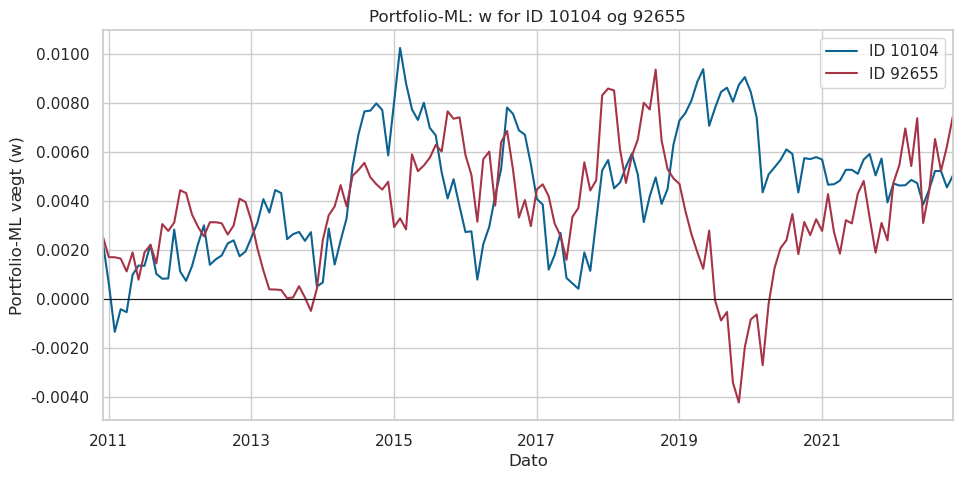

In [106]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

# --------------------------------------------------
# 1) Slå system‑LaTeX helt fra
mpl.rcParams['text.usetex']              = False
# 2) Undgå Unicode‑minus glyfen
mpl.rcParams['axes.unicode_minus']       = False
# 3) Brug Matplotlibs interne mathtext til *tallet* (ikke fuld LaTeX)
mpl.rcParams['axes.formatter.use_mathtext'] = True
# --------------------------------------------------

# 0) Hent og forbered
df = pfml["w"]
ids = [10104, 92655]
sub = df[df['id'].isin(ids)][['eom','id','w']].copy()
sub['eom'] = pd.to_datetime(sub['eom'])
sub.set_index('eom', inplace=True)

# 1) Plot
fig, ax = plt.subplots(figsize=(10,5))
for i, grp in sub.groupby('id'):
    grp['w'].plot(ax=ax, label=f'ID {i}')

# 2) Styling
ax.axhline(0, color='k', linewidth=0.8)
ax.set_xlabel('Dato')
ax.set_ylabel('Portfolio‑ML vægt (w)')
ax.set_title('Portfolio‑ML: w for ID 10104 og 92655')
ax.legend()

# 3) Tving ASCII minus og fast decimalformat på y‑aksen
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

# 4) I stedet for tight_layout(), gør lidt luft manuelt:
fig.subplots_adjust(left=0.10, right=0.95, top=0.90, bottom=0.12)

plt.show()


In [107]:
# Antag at din DataFrame hedder fx mkt_w
df = mkt['w']  # eller hvad du har kaldt den

# 1) Filtrér til netop 2022-11-30
date = '2022-11-30'
subset = df[df['eom'] == date].copy()

# 2) Find indeks for max og min
idx_max = subset['w'].idxmax()
idx_min = subset['w'].idxmin()

# 3) Hent rækkerne
row_max = subset.loc[idx_max]
row_min = subset.loc[idx_min]

print(f"Størst vægt på {date}: ID {int(row_max['id'])} med w = {row_max['w']:.6f}")
print(f"Mindst vægt på {date}: ID {int(row_min['id'])} med w = {row_min['w']:.6f}")


Størst vægt på 2022-11-30: ID 14593 med w = 0.079698
Mindst vægt på 2022-11-30: ID 78876 med w = 0.000017


In [108]:
# Antag at din 'w'-DataFrame hedder df_w
df_w = mkt['w']  # skift til din egen variabel hvis den hedder noget andet

# 1) Find ID med mindste w på 2022-11-30
date1 = '2022-11-30'
subset1 = df_w[df_w['eom'] == date1]
id_min = int(subset1.nsmallest(8, 'w')['id'].iloc[-1])
w_min   = subset1['w'].min()
print(f"Mindste vægt d. {date1}: ID {id_min} med w = {w_min:.6f}")

# 2) Opslag på 2011-01-31 for samme ID
date2 = '2011-01-31'
row_old = df_w[(df_w['eom'] == date2) & (df_w['id'] == id_min)]

if not row_old.empty:
    w_old = row_old['w'].iloc[0]
    print(f"Samme ID {id_min} d. {date2} havde w = {w_old:.6f}")
else:
    print(f"ID {id_min} findes ikke på {date2}")


Mindste vægt d. 2022-11-30: ID 85796 med w = 0.000017
Samme ID 85796 d. 2011-01-31 havde w = 0.000079


In [109]:
subset_hps_w = static_no_demean["hps"][
    static_no_demean["hps"]["eom_ret"].isin(static_no_demean["pf"]["eom_ret"]) &
    (static_no_demean["hps"]["k"] == 1) &
    (static_no_demean["hps"]["g"] == 0) &
    (static_no_demean["hps"]["u"] == 1)
].copy()

#subset_hps_w["eom_ret"] = pd.to_datetime(subset_hps_w["eom_ret"])
#subset_hps_w = subset_hps_w[["eom_ret", "inv", "shorting", "turnover", "r", "tc"]]
#subset_hps_w["type"] = "Static-ML"

In [110]:
subset_hps_w

,inv,shorting,turnover,r,tc,eom_ret,hp_no,k,g,u,cum_mean_r2,cum_mean_r,cum_var,cum_obj,rank
1704,16.513874,8.212675,3.806620,0.013361,0.006828,2011-01-31,6,1.0,0.0,1.0,0.020372,0.034927,0.019152,-0.049300,21.0
1705,16.358828,8.115576,3.849176,0.081461,0.006795,2011-02-28,6,1.0,0.0,1.0,0.020260,0.035308,0.019013,-0.049063,21.0
1706,17.096613,8.554738,4.261502,0.046131,0.008175,2011-03-31,6,1.0,0.0,1.0,0.020112,0.035396,0.018859,-0.049122,22.0
1707,17.915774,8.922859,3.745448,0.073570,0.006359,2011-04-30,6,1.0,0.0,1.0,0.019994,0.035704,0.018719,-0.048939,22.0
1708,17.694986,8.840341,3.885059,0.048012,0.007564,2011-05-31,6,1.0,0.0,1.0,0.019852,0.035802,0.018570,-0.048967,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,9.831982,4.678576,0.757488,-0.002087,0.000604,2022-08-31,6,1.0,0.0,1.0,0.011732,0.027113,0.010997,-0.050129,24.0
1844,9.835233,4.680649,0.816882,-0.029324,0.000661,2022-09-30,6,1.0,0.0,1.0,0.011691,0.026896,0.010967,-0.050262,24.0
1845,9.972444,4.763740,0.774400,0.044578,0.000624,2022-10-31,6,1.0,0.0,1.0,0.011654,0.026964,0.010927,-0.050111,24.0
1846,10.156611,4.846850,0.780612,0.065934,0.000595,2022-11-30,6,1.0,0.0,1.0,0.011626,0.027112,0.010891,-0.049879,24.0


In [111]:
static_no_demean["hps"]

,inv,shorting,turnover,r,tc,eom_ret,hp_no,k,g,u,cum_mean_r2,cum_mean_r,cum_var,cum_obj,rank
0,0.917535,0.364909,1.244338,0.036496,0.000930,2001-01-31,0,1.0,0.0,0.25,0.001332,0.036496,0.000000,0.035566,19.0
1,1.094022,0.468557,0.766166,0.020991,0.000440,2001-02-28,0,1.0,0.0,0.25,0.000886,0.028743,0.000060,0.027908,20.0
2,1.403057,0.616113,0.748456,0.009123,0.000402,2001-03-31,0,1.0,0.0,0.25,0.000619,0.022203,0.000126,0.021303,20.0
3,1.686092,0.738592,0.857932,0.028696,0.000481,2001-04-30,0,1.0,0.0,0.25,0.000670,0.023826,0.000102,0.022903,20.0
4,1.746973,0.767725,0.923824,0.019049,0.000547,2001-05-31,0,1.0,0.0,0.25,0.000608,0.022871,0.000085,0.021938,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,3.520786,1.536554,1.139908,-0.026419,0.001988,2022-08-31,26,0.2,2.0,1.00,0.004384,0.019083,0.004020,-0.034625,21.0
7124,3.516032,1.542589,1.076485,-0.019365,0.001859,2022-09-30,26,0.2,2.0,1.00,0.004369,0.018935,0.004010,-0.034651,21.0
7125,3.534707,1.564077,1.070975,0.068274,0.001827,2022-10-31,26,0.2,2.0,1.00,0.004370,0.019124,0.004004,-0.034342,21.0
7126,3.491180,1.536381,1.117419,0.017606,0.002001,2022-11-30,26,0.2,2.0,1.00,0.004354,0.019118,0.003989,-0.034227,21.0


In [112]:
#10104,ORCL
#11308,KO,COCA COLA CO,2023-12-29
#87717,EXPD
#92655,UNH,UNITEDHEALTH GROUP INC
#86580,NVDA,NVIDIA CORP,2023-12-29
#10104: ORCL
#11308: KO
#87717: EXPD
#92655: UNH
#86580: NVDA

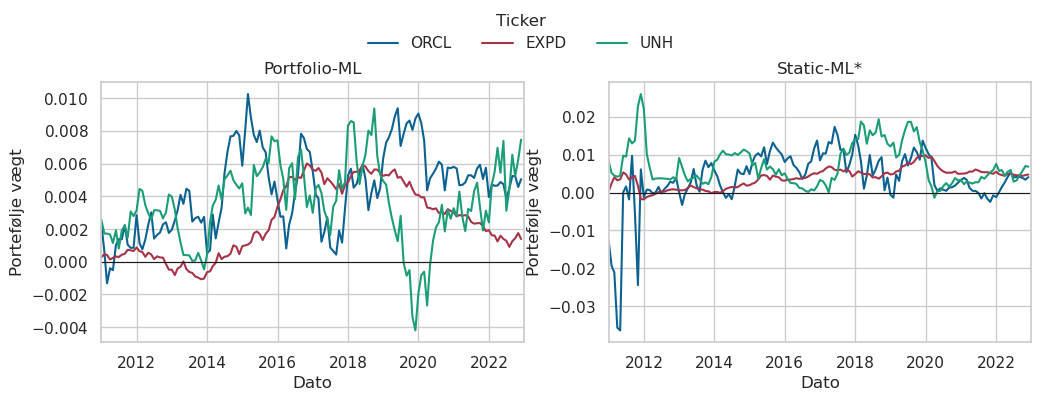

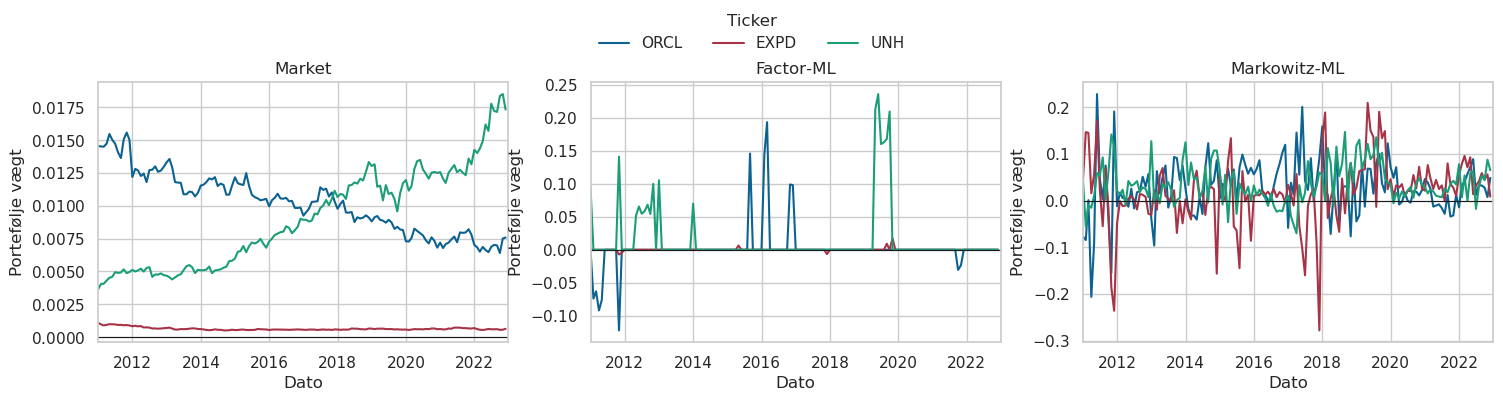

In [115]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict

# ID’erne og deres tickers
#ids = [10104, 11308, 87717, 92655, 86580]
ids = [10104, 87717, 92655]
id2ticker = {
    10104: 'ORCL',
    #11308: 'KO',
    87717: 'EXPD',
    92655: 'UNH',
    #86580: 'NVDA',
}

# Dine “w”-DataFrames
methods = {
    'Portfolio‑ML':   pfml['w'],
    'Static‑ML*':     static_no_demean['w'],
    'Markowitz‑ML':   tpf['w'],
    'Market':         mkt['w'],
    'Factor‑ML':      factor_ml['w'],
}

def plot_grid(selected_methods, ncols, figsize, start_date, end_date):
    """
    Tegn ncols subplots i én række, alle starter på start_date og stopper på end_date.
    Returnerer fig, unikke handles og labels til fælles legend.
    """
    fig, axes = plt.subplots(1, ncols, figsize=figsize, sharex=False)
    for ax, (name, df_w) in zip(axes, selected_methods.items()):
        sub = df_w[df_w['id'].isin(ids)][['eom','id','w']].copy()
        sub['eom'] = pd.to_datetime(sub['eom'])
        sub.set_index('eom', inplace=True)

        for i, grp in sub.groupby('id'):
            ax.plot(grp.index, grp['w'], label=id2ticker[i])
        ax.axhline(0, color='k', linewidth=0.8)
        ax.set_title(name)
        ax.set_xlabel('Dato')
        ax.set_ylabel('Portefølje vægt')

        # Sæt x‑aksens interval
        ax.set_xlim(left=start_date, right=end_date)

    # Saml alle handles og labels
    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    # Fjern dubletter – bevar rækkefølgen
    unique = OrderedDict(zip(labels, handles))
    return fig, list(unique.values()), list(unique.keys())


# Konverter start- og slutdato til datetime
start = pd.to_datetime('2010-12-31')
end   = pd.to_datetime('2022-12-31')

# --- Figur 1: ML‑metoder (2 plots) ---
first_methods = {k: methods[k] for k in ['Portfolio‑ML','Static‑ML*']}
fig1, h1, l1 = plot_grid(
    first_methods,
    ncols=2,
    figsize=(12, 4),
    start_date=start,
    end_date=end
)
fig1.legend(
    handles=h1,
    labels=l1,
    title='Ticker',
    loc='upper center',
    ncol=len(l1),
    frameon=False
)
fig1.subplots_adjust(top=0.80, bottom=0.15)
fig1.savefig(
    os.path.join(output_folder, "portefølje_vægte_udvalgte.png"),
    dpi=300,
    bbox_inches='tight'
)

# --- Figur 2: Market vs. Factor‑ML + Markowitz‑ML (3 plots) ---
second_methods = {k: methods[k] for k in ['Market','Factor‑ML','Markowitz‑ML']}
fig2, h2, l2 = plot_grid(
    second_methods,
    ncols=3,
    figsize=(18, 4),
    start_date=start,
    end_date=end
)
fig2.legend(
    handles=h2,
    labels=l2,
    title='Ticker',
    loc='upper center',
    ncol=len(l2),
    frameon=False
)
fig2.subplots_adjust(top=0.80, bottom=0.15)
fig2.savefig(
    os.path.join(output_folder, "portefølje_vægte_udvalgte_bm.png"),
    dpi=300,
    bbox_inches='tight'
)

plt.show()


In [132]:
import datetime

def expected_risk_fun(ws, dates, cov_list):
    """
    Beregn forventet porteføljevarians for hver portefølje (metode) og dato.

    Parametre:
      - ws (pd.DataFrame): DataFrame med porteføljeoplysninger med kolonnerne 
           'id' (asset id), 'type' (metode, fx "Portfolio-ML"), 'eom' (dato) og 'w' (aktivets vægt).
      - dates (list): Liste af datoer (pd.Timestamp, datetime eller str) for udvælgelse.
      - cov_list (dict): Dictionary med kovariansmatricer. Nøglerne skal være datoer i formatet 'YYYY-MM-DD'.
    
    Returnerer:
      pd.DataFrame med kolonnerne 'type', 'pf_var' og 'eom'.
    """
    # Sørg for, at ws er sorteret ensartet efter type, eom og id
    ws_sorted = ws.sort_values(by=['type', 'eom', 'id'])
    types = ws_sorted['type'].unique()
    
    # Lav en ordbog, der grupperer ws_sorted efter eom.
    # Nøglerne konverteres til str i formatet 'YYYY-MM-DD'
    w_list = {}
    for eom_val, group in ws_sorted.groupby('eom'):
        if isinstance(eom_val, (pd.Timestamp, datetime.datetime)):
            key = eom_val.strftime('%Y-%m-%d')
        else:
            key = str(eom_val)
        w_list[key] = group.copy()
    
    results = []
    for d in dates:
        # Konverter dato d til string i formatet 'YYYY-MM-DD'
        if isinstance(d, (pd.Timestamp, datetime.datetime)):
            d_str = d.strftime('%Y-%m-%d')
        else:
            d_str = str(d)
        w_sub = w_list.get(d_str)
        if w_sub is None:
            continue  # Ingen data for denne dato
        # Sorter w_sub efter id for konsistens
        w_sub = w_sub.sort_values(by='id')
        # Få unikke asset ids (som strenge)
        ids = w_sub['id'].unique().astype(str)
        # Hent sigma for denne dato; nøglen i cov_list skal matche d_str
        sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
        for t in types:
            # Vælg de rækker, hvor 'type' == t, og sorter efter id for at sikre, at rækkefølgen stemmer overens
            subset = w_sub[w_sub['type'] == t].sort_values(by='id')
            # Antag, at der for hver dato og type er én observation pr. aktiv,
            # så kolonnen 'w' udgør et vektor med vægte
            w_vec = subset['w'].values.astype(float)
            # Beregn porteføljevariansen: w^T * sigma * w
            pf_var = np.dot(np.dot(w_vec.T, sigma), w_vec)
            results.append({'type': t, 'pf_var': float(pf_var), 'eom': d_str})
    return pd.DataFrame(results)

In [134]:
import seaborn as sns
main_types = ["Portfolio-ML","Markowitz-ML", "Factor-ML", "Market", "Rank-ML", "Minimum Variance", "Static-ML", "Static-ML*"]
# 1. Kombiner portefølje-dataframes med tildelt type
pfml_w = pfml['w'].copy()
pfml_w['type'] = "Portfolio-ML"

tpf_w = tpf['w'].copy()
tpf_w['type'] = "Markowitz-ML"

static_w = static_no_demean['w'].copy()
if 'pred_ld1' in static_w.columns:
    static_w = static_w.drop(columns=['pred_ld1'])
static_w['type'] = "Static-ML*"

factor_ml_w = factor_ml['w'].copy()
factor_ml_w['type'] = "Factor-ML"

ws = pd.concat([pfml_w, tpf_w, static_w, factor_ml_w], ignore_index=True)

# Sørg for, at type-kolonnen har den ønskede rækkefølge
ws['type'] = pd.Categorical(ws['type'], categories=pf_order, ordered=True)

# 2. Beregn forventet porteføljerisiko (forvent, at funktionen returnerer en DataFrame med fx pf_var og eom)
pf_vars = expected_risk_fun(ws, dates_oos, barra_cov)

# 3. Forbered pfs-data. I R beregnes eom som eom_ret + 1 måned - 1 dag.
pfs2 = pfs.copy()
pfs2['eom'] = pd.to_datetime(pfs2['eom_ret'])
pfs2 = pfs2[['type', 'eom', 'inv', 'turnover']]

# Sørg for, at eom-kolonnen i både pf_vars og pfs2 er datetime64[ns]
pf_vars['eom'] = pd.to_datetime(pf_vars['eom'])
pfs2['eom'] = pd.to_datetime(pfs2['eom'])
# 4. Join pf_vars med pfs2 på 'type' og 'eom'
comp_stats = pf_vars.merge(pfs2, on=['type','eom'], how='left')


# 4. Join pf_vars med pfs2 på 'type' og 'eom'
comp_stats = pf_vars.merge(pfs2, on=['type','eom'], how='left')

# 5. Filtrer for de hovedtyper, vi vil medtage
comp_stats = comp_stats[comp_stats['type'].isin(main_types)]

# 6. Udregn eks-ante volatilitet: e_sd = sqrt(pf_var * 252)
comp_stats['e_sd'] = np.sqrt(comp_stats['pf_var'] * 252)
comp_stats = comp_stats.drop(columns=['pf_var'])

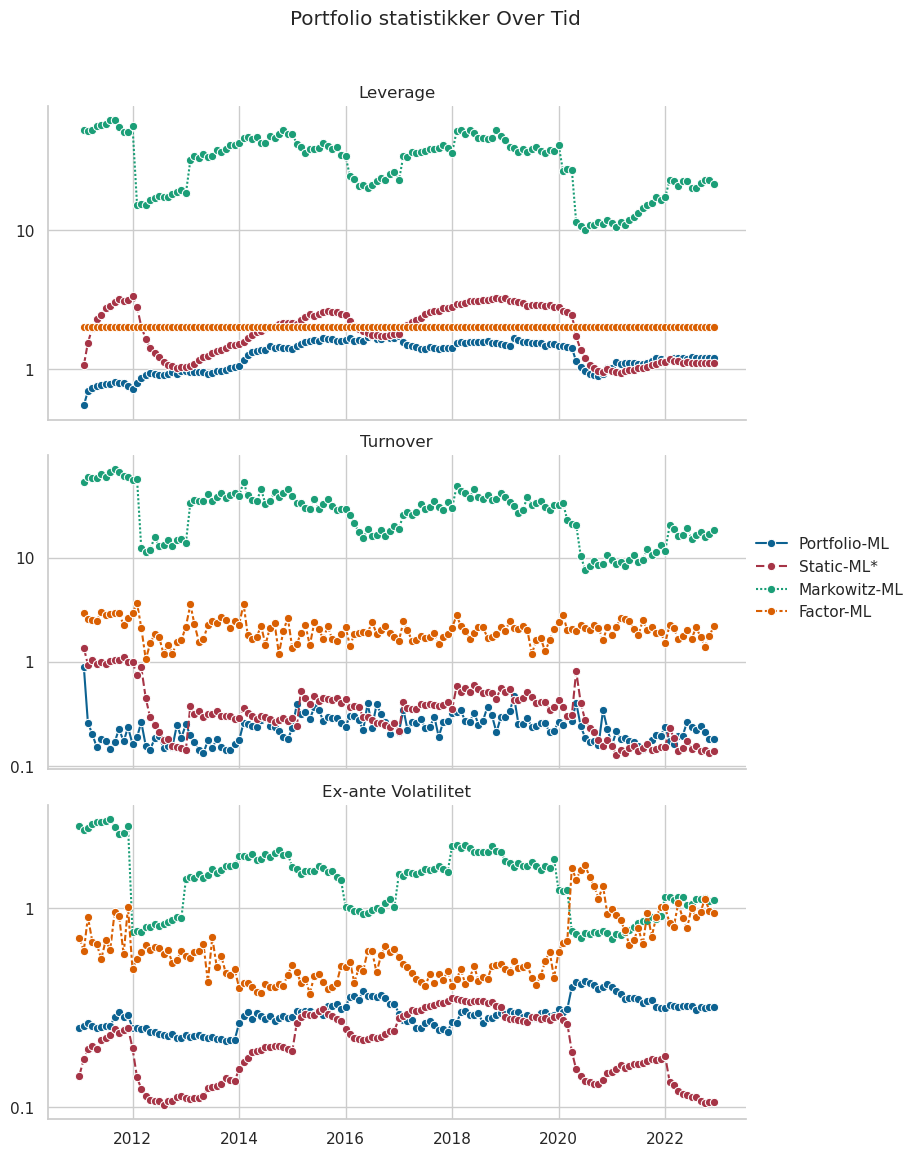

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 7. Pivot longer
comp_stats_melt = comp_stats.melt(
    id_vars=['type', 'eom'],
    var_name='name',
    value_name='value'
)

# 8. Omdøb til flotte labels
name_map = {
    'e_sd': 'Ex-ante Volatilitet',
    'turnover': 'Turnover',
    'inv': 'Leverage'
}
comp_stats_melt['name'] = comp_stats_melt['name'].map(name_map)

# 9. Plot med seaborn FacetGrid
g = sns.FacetGrid(
    comp_stats_melt,
    col="name",
    col_wrap=1,
    sharey=False,
    height=4,
    aspect=2
)
g.map_dataframe(
    sns.lineplot,
    x="eom",
    y="value",
    hue="type",
    style="type",
    marker="o"
)

# Log‐skala på y‐aksen
g.set(yscale="log")

# Fjern "name =" fra titlerne
g.set_titles("{col_name}")

# Akse‐labels og legend
g.set_axis_labels("", "")
g.add_legend(title="")

# Supertitel og layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Portfolio statistikker Over Tid")

# Formatter y‐aksen til almindelig notation (10, 1, 0.1, …)
formatter = FuncFormatter(lambda y, pos: f"{y:g}")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(formatter)
plt.savefig(
    os.path.join(output_folder, "port_statistikker.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


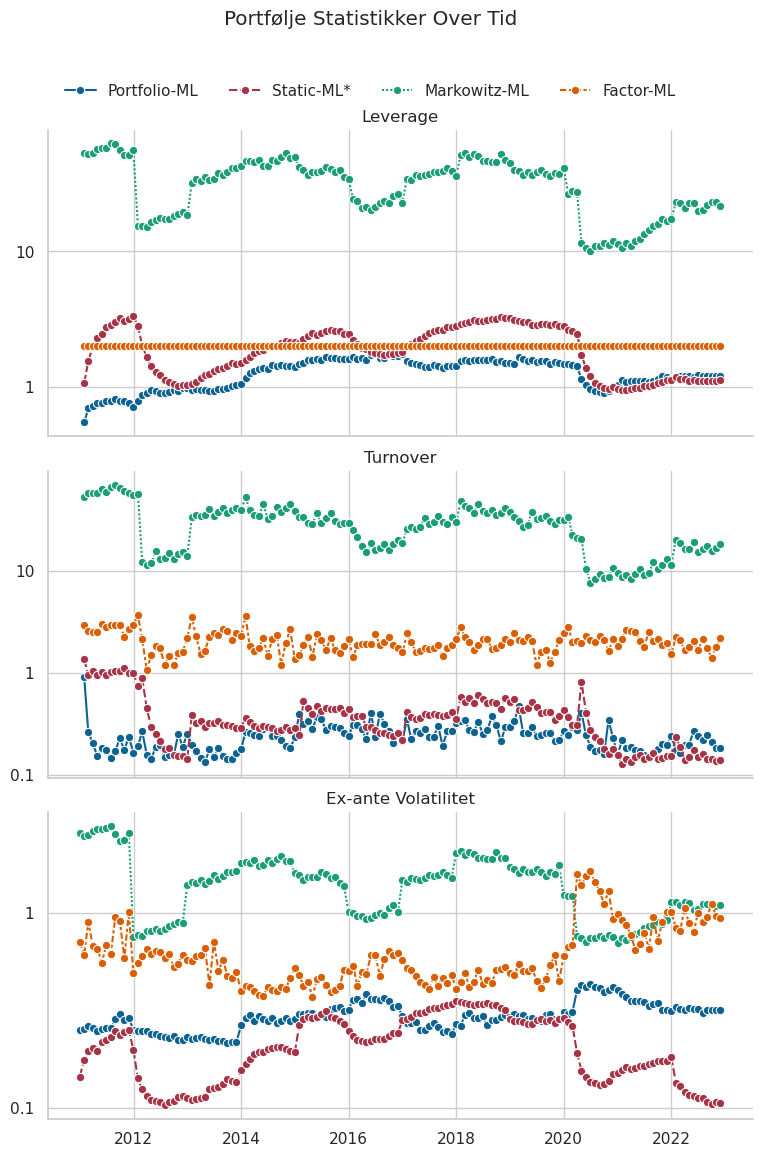

In [140]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 7. Pivot longer
comp_stats_melt = comp_stats.melt(
    id_vars=['type', 'eom'],
    var_name='name',
    value_name='value'
)

# 8. Omdøb til flotte labels
name_map = {
    'e_sd': 'Ex-ante Volatilitet',
    'turnover': 'Turnover',
    'inv': 'Leverage'
}
comp_stats_melt['name'] = comp_stats_melt['name'].map(name_map)

# 9. Plot med seaborn FacetGrid
g = sns.FacetGrid(
    comp_stats_melt,
    col="name",
    col_wrap=1,
    sharey=False,
    height=4,
    aspect=2
)
g.map_dataframe(
    sns.lineplot,
    x="eom",
    y="value",
    hue="type",
    style="type",
    marker="o"
)

# Log‐skala på y‐aksen
g.set(yscale="log")

# Fjern "name =" fra titlerne
g.set_titles("{col_name}")

# Fjern akse‐labels
g.set_axis_labels("", "")

# Formatter y‐aksen til almindelig notation (10, 1, 0.1, …)
formatter = FuncFormatter(lambda y, pos: f"{y:g}")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(formatter)

# Supertitel
fig = g.fig
fig.suptitle("Portfølje Statistikker Over Tid")

# Hent legend‐handles og labels fra første subplot
handles, labels = g.axes.flat[0].get_legend_handles_labels()

# Tilføj legend på figur‐niveau lige under suptitlen, uden boks
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.93),  # justér evt. y‐værdien til præcis under titlen
    ncol=len(labels),
    frameon=False
)

# Justér top‐margin så der er plads til både legend og suptitle
plt.subplots_adjust(top=0.88)

# Gem og vis
plt.savefig(
    os.path.join(output_folder, "port_statistikker.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


# Barra cov

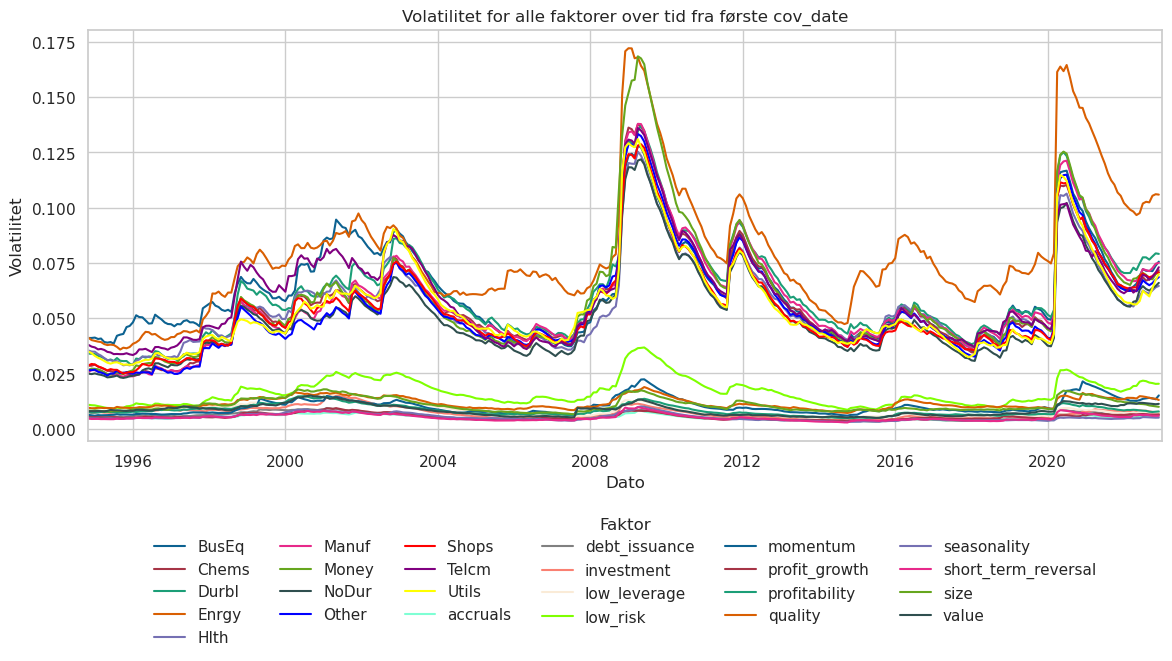

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Antag vol_data og factor_names er klar fra før ---
# vol_data = pd.DataFrame(records) …
# factor_names = barra_cov[first_date]['fct_cov'].columns.tolist()

# Definér dine start‑ og slutdatoer
start = pd.to_datetime('1994-10-31')
end   = pd.to_datetime('2022-12-31')

fig, ax = plt.subplots(figsize=(12, 6))

# 1) Tegn én linje per faktor
for factor in factor_names:
    subset = vol_data[vol_data['factor'] == factor]
    ax.plot(subset['date'], subset['vol'], label=factor)

# 2) Begræns x‑aksen
ax.set_xlim(start, end)

# 3) Titler og akser
ax.set_title("Volatilitet for alle faktorer over tid fra første cov_date")
ax.set_xlabel("Dato")
ax.set_ylabel("Volatilitet")

# 4) Hent handles+labels til legend
handles, labels = ax.get_legend_handles_labels()

# 5) Placér legend under plottet, vandret
ax.legend(
    handles, labels,
    title="Faktor",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # midt under aksen
    ncol=6,                       # tilpas kolonner efter antal faktorer
    frameon=False
)

# 6) Gør plads i bunden til legend
plt.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.savefig(
    os.path.join(output_folder, "volatilitet_for_alle_fak_hele_perioden.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


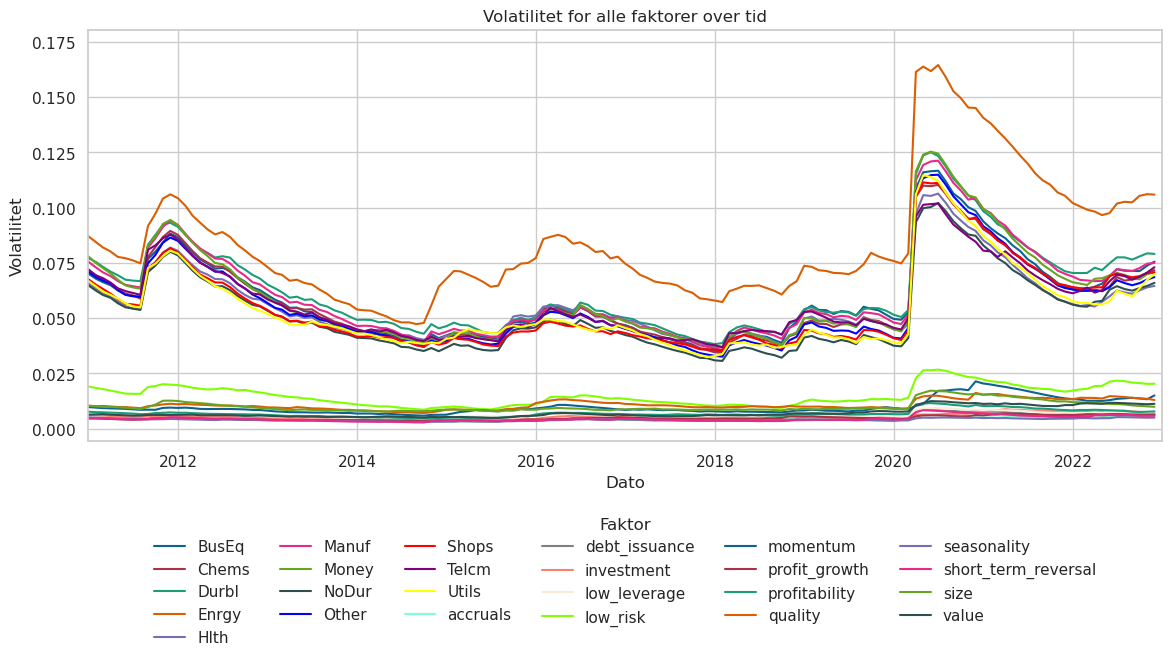

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Antag vol_data og factor_names er klar fra før ---
# vol_data = pd.DataFrame(records) …
# factor_names = barra_cov[first_date]['fct_cov'].columns.tolist()

# Definér dine start‑ og slutdatoer
start = pd.to_datetime('2010-12-31')
end   = pd.to_datetime('2022-12-31')

fig, ax = plt.subplots(figsize=(12, 6))

# 1) Tegn én linje per faktor
for factor in factor_names:
    subset = vol_data[vol_data['factor'] == factor]
    ax.plot(subset['date'], subset['vol'], label=factor)

# 2) Begræns x‑aksen
ax.set_xlim(start, end)

# 3) Titler og akser
ax.set_title("Volatilitet for alle faktorer over tid")
ax.set_xlabel("Dato")
ax.set_ylabel("Volatilitet")

# 4) Hent handles+labels til legend
handles, labels = ax.get_legend_handles_labels()

# 5) Placér legend under plottet, vandret
ax.legend(
    handles, labels,
    title="Faktor",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # midt under aksen
    ncol=6,                       # tilpas kolonner efter antal faktorer
    frameon=False
)

# 6) Gør plads i bunden til legend
plt.tight_layout()
fig.subplots_adjust(bottom=0.25)
fig.savefig(
    os.path.join(output_folder, "volatilitet_for_alle_fak_hele_oos_periode.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


In [236]:
pfml['w']

,id,eom,w_start,w,tr_ld1,mu_ld1,match_count,w_start_diff
0,10032,2010-12-31,0.000115,0.000288,-0.126016,0.020052,0,0.0
1,10032,2011-01-31,0.000247,0.000328,0.162330,0.038821,0,0.0
2,10032,2011-02-28,0.000367,0.000246,0.115528,0.003383,0,0.0
3,10032,2011-03-31,0.000273,0.000304,0.040834,0.027662,0,0.0
4,10032,2011-04-30,0.000308,0.000229,0.021637,-0.015071,0,0.0
...,...,...,...,...,...,...,...,...
102047,92655,2022-07-31,0.003003,0.004395,-0.043528,-0.036188,0,0.0
102048,92655,2022-08-31,0.004361,0.006534,-0.024368,-0.091370,0,0.0
102049,92655,2022-09-30,0.007016,0.005237,0.098793,0.081350,0,0.0
102050,92655,2022-10-31,0.005322,0.006234,-0.013868,0.051329,0,0.0


# Daglig data plot 

In [258]:
# De id'er du vil have med
#10104,ORCL,ORACLE CORP,2023-12-29
#10107,MSFT,MICROSOFT CORP,2023-12-29
#10138,TROW,T ROWE PRICE GROUP INC,2023-12-29
#10696,FI,FISERV INC,2023-12-29
#11308,KO,COCA COLA CO,2023-12-29
ids = [10104, 10107, 10138, 10696, 11308]
daglig_path  = "./Data/usa_dsf.parquet" 
# Læs kun kolonnerne 'id', 'date' og 'ret_exc' og kun de rækker
# hvor 'id' er i din liste
df = pd.read_parquet(
    daglig_path,
    engine='pyarrow',
    columns=['id', 'date', 'ret_exc'],
    filters=[('id', 'in', ids)]
)

print(df.head())

      id        date   ret_exc
0  10104  1986-03-13  0.023958
1  10104  1986-03-14  0.035219
2  10104  1986-03-17 -0.023141
3  10104  1986-03-18 -0.023676
4  10104  1986-03-19 -0.018248


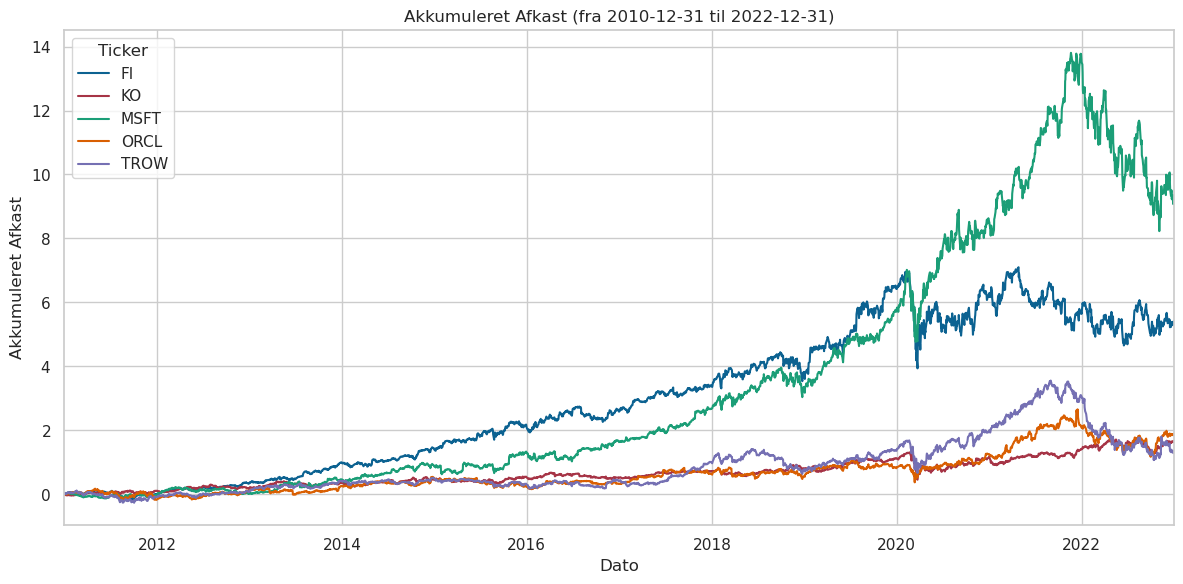

In [270]:
import pandas as pd
import matplotlib.pyplot as plt

# ID’er + mapping
ids = [10104, 10107, 10138, 10696, 11308]
id2ticker = {
    10104: 'ORCL', 10107: 'MSFT', 10138: 'TROW',
    10696: 'FI',   11308: 'KO',
}

# Læs ind (kun disse id’er)
df = pd.read_parquet(
    daglig_path,
    engine='pyarrow',
    columns=['id','date','ret_exc'],
    filters=[('id','in', ids)]
)
df['ticker'] = df['id'].map(id2ticker)
df['date']   = pd.to_datetime(df['date'], format='%Y%m%d')

# Pivot til bredt format og sorter
ret_pivot = df.pivot(index='date', columns='ticker', values='ret_exc').sort_index()

# Definér start/slut og filtrér DÈR
start = pd.to_datetime('2010-12-31')
end   = pd.to_datetime('2022-12-31')
ret_pivot = ret_pivot.loc[start:end]

# Nu kumuleres direkte – første observation er 0
cumret = (1 + ret_pivot).cumprod() - 1

# Plot
fig, ax = plt.subplots(figsize=(12,6))
for ticker in cumret.columns:
    ax.plot(cumret.index, cumret[ticker], label=ticker)

ax.set_xlim(start, end)
ax.set_title("Akkumuleret Afkast (fra 2010-12-31 til 2022-12-31)")
ax.set_xlabel("Dato")
ax.set_ylabel("Akkumuleret Afkast")
ax.legend(title="Ticker", loc='upper left')
ax.grid(True)
plt.tight_layout()
fig.savefig(
    os.path.join(output_folder, "akk_afkast_oos_periode.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


In [273]:
# 1) Annualiseringsfaktor (dagligt → årligt)
ann_factor = 252

# 2) Aritmetisk annualiseret afkast:
#    gennemsnitlig daglig retur * 252
ann_return = ret_pivot.mean() * ann_factor

# 3) Annualiseret volatilitet
ann_vol = ret_pivot.std() * np.sqrt(ann_factor)

# 4) Sharpe‑ratio (uden risikofri rente)
sharpe = ann_return / ann_vol

# … antag at du allerede har ann_return, ann_vol og sharpe beregnet …  

# Sammensæt i én DataFrame
summary = pd.DataFrame({
    'Årligt Aritmetisk Afkast (%)': ann_return * 100,
    'Årlig Volatilitet (%)':        ann_vol     * 100,
    'Sharpe Ratio':                 sharpe
})

# Afrund og vis
summary = summary.round({
    'Årligt Aritmetisk Afkast (%)': 2,
    'Årlig Volatilitet (%)':        2,
    'Sharpe Ratio':                 2
})

print(summary)


        Årligt Aritmetisk Afkast (%)  Årlig Volatilitet (%)  Sharpe Ratio
ticker                                                                   
FI                             19.04                  33.48          0.57
KO                             12.23                  23.37          0.52
MSFT                           25.38                  33.84          0.75
ORCL                           27.95                  46.73          0.60
TROW                           19.78                  37.85          0.52


In [274]:
latex = summary.to_latex(
    caption="Årligt aritmetisk afkast, volatilitet og Sharpe‐ratio for udvalgte tickere",
    label="tab:performance_summary",
    float_format="%.2f",
    index=True,         # hvis du vil have tickers som første kolonne
    header=True,
    column_format="lrrr",  # l = venstre, rrr = tre højrestillede kolonner
    escape=False         # så danske tegn ikke bliver escaped
)

print(latex)

\begin{table}
\caption{Årligt aritmetisk afkast, volatilitet og Sharpe‐ratio for udvalgte tickere}
\label{tab:performance_summary}
\begin{tabular}{lrrr}
\toprule
 & Årligt Aritmetisk Afkast (%) & Årlig Volatilitet (%) & Sharpe Ratio \\
ticker &  &  &  \\
\midrule
FI & 19.04 & 33.48 & 0.57 \\
KO & 12.23 & 23.37 & 0.52 \\
MSFT & 25.38 & 33.84 & 0.75 \\
ORCL & 27.95 & 46.73 & 0.60 \\
TROW & 19.78 & 37.85 & 0.52 \\
\bottomrule
\end{tabular}
\end{table}



In [275]:
import numpy as np
import pandas as pd

# 1) Annualiseringsfaktor (dagligt → årligt)
ann_factor = 252

# … antag at ret_pivot er din DataFrame med daglige afkast …

# 2) Aritmetisk annualiseret afkast:
ann_return = ret_pivot.mean() * ann_factor

# 3) Annualiseret volatilitet
ann_vol = ret_pivot.std() * np.sqrt(ann_factor)

# 4) Sharpe‑ratio (uden risikofri rente)
sharpe = ann_return / ann_vol

# 5) Geometrisk annualiseret afkast:
#    exp(gennemsnit af daglige log-returns * 252) - 1
log_return = np.log1p(ret_pivot)               # log(1 + r_t)
geom_return = np.exp(log_return.mean() * ann_factor) - 1

# … sammensæt alt i én DataFrame …
summary = pd.DataFrame({
    'Årligt Aritmetisk Afkast (%)': (ann_return * 100),
    'Årlig Volatilitet (%)':        (ann_vol     * 100),
    'Sharpe Ratio':                  sharpe,
    'Årligt Geometrisk Afkast (%)':  (geom_return * 100)
})

# Afrund og vis
summary = summary.round({
    'Årligt Aritmetisk Afkast (%)': 2,
    'Årlig Volatilitet (%)':        2,
    'Sharpe Ratio':                 2,
    'Årligt Geometrisk Afkast (%)': 2
})

print(summary)


        Årligt Aritmetisk Afkast (%)  Årlig Volatilitet (%)  Sharpe Ratio  \
ticker                                                                      
FI                             19.04                  33.48          0.57   
KO                             12.23                  23.37          0.52   
MSFT                           25.38                  33.84          0.75   
ORCL                           27.95                  46.73          0.60   
TROW                           19.78                  37.85          0.52   

        Årligt Geometrisk Afkast (%)  
ticker                                
FI                             14.39  
KO                              9.96  
MSFT                           21.68  
ORCL                           18.62  
TROW                           13.48  


In [276]:
# … forudsat at du allerede har geom_return med i summary …
summary['Årligt Geometrisk Afkast (%)'] = geom_return * 100

# Til LaTeX: fire tal-kolonner nu (aritm., vol, Sharpe, geom.)
latex = summary.to_latex(
    caption="Årligt aritmetisk og geometrisk afkast, volatilitet og Sharpe‐ratio for udvalgte tickere",
    label="tab:performance_summary",
    float_format="%.2f",
    index=True,            # beholder tickers som første kolonne
    header=True,
    column_format="lrrrr", # l = venstre (ticker), rrrr = fire højrestillede kolonner
    escape=False           # sådan at danske tegn bevares
)

print(latex)


\begin{table}
\caption{Årligt aritmetisk og geometrisk afkast, volatilitet og Sharpe‐ratio for udvalgte tickere}
\label{tab:performance_summary}
\begin{tabular}{lrrrr}
\toprule
 & Årligt Aritmetisk Afkast (%) & Årlig Volatilitet (%) & Sharpe Ratio & Årligt Geometrisk Afkast (%) \\
ticker &  &  &  &  \\
\midrule
FI & 19.04 & 33.48 & 0.57 & 14.39 \\
KO & 12.23 & 23.37 & 0.52 & 9.96 \\
MSFT & 25.38 & 33.84 & 0.75 & 21.68 \\
ORCL & 27.95 & 46.73 & 0.60 & 18.62 \\
TROW & 19.78 & 37.85 & 0.52 & 13.48 \\
\bottomrule
\end{tabular}
\end{table}

